The aim of this notebook is to train and validate the basic SPDNet without augmenting the original dataset.
Since computing the input correlation matrices and randomising prior to 

In [1]:
%cd torchspdnet_untouched 

# %cd torchspdnet

import os, sys
sys.path.append(os.getcwd())

/Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/torchspdnet_untouched


In [2]:
# Preliminaries 
import numpy as np
import pandas as pd
import time

from random import randint
import os
import shutil

from numpy import sqrt 
import torch as th
from scipy.stats import t
import sys

from datetime import datetime
from datetime import timedelta
import missingno as msno

# Enable anomaly detection
th.autograd.set_detect_anomaly(True)

import fastcluster
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

import networkx as nx
from scipy.spatial.distance import squareform

from scipy.stats import rankdata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import random
random.seed(27)

import torch.nn as nn
from torch.utils import data

import torchspdnet.nn as spdnet
from torchspdnet.optimizers import MixOptimizer

from collections import Counter

In [3]:
df = pd.read_excel('/Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/JALSH_data.xlsx', sheet_name = 0)
market_cap = pd.read_excel('/Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/JALSH_data.xlsx', sheet_name = 1)

df['Dates'] = pd.to_datetime(df['Dates'], infer_datetime_format=True)
market_cap['Dates'] = pd.to_datetime(market_cap['Dates'], infer_datetime_format=True)

df.index = df['Dates']
del df['Dates']
df = df.sort_index()

market_cap.index = market_cap['Dates']
del market_cap['Dates']
market_cap = market_cap.sort_index()

returns = df.pct_change(periods=1)
returns.tail()

,ABG SJ Equity,ADH SJ Equity,AEL SJ Equity,AFE SJ Equity,AFH SJ Equity,AFT SJ Equity,AGL SJ Equity,AIL SJ Equity,AIP SJ Equity,AMS SJ Equity,...,TGA SJ Equity,THA SJ Equity,TKG SJ Equity,TRU SJ Equity,TSG SJ Equity,TXT SJ Equity,VKE SJ Equity,VOD SJ Equity,WBO SJ Equity,WHL SJ Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2023-12-07,-0.023719,0.000000,0.000000,-0.040570,-0.061489,-0.010539,0.001028,0.036961,-0.034783,0.026879,...,0.020618,0.000705,-0.052000,-0.025654,0.019185,0.000000,-0.014184,-0.015575,0.000077,-0.021780
2023-12-08,-0.063146,0.000000,-0.010000,-0.028571,0.029310,0.009941,-0.133194,-0.049505,-0.008108,-0.003209,...,0.016547,0.014085,-0.008439,0.015449,-0.005490,0.000000,-0.012950,0.010513,0.004461,0.013804
2023-12-11,-0.002443,0.004800,-0.055556,0.027353,0.005025,0.013359,-0.041542,-0.004167,0.023978,0.019262,...,-0.005290,0.006944,-0.025532,-0.018918,0.000000,0.009730,0.026239,0.003030,0.008347,0.001757
2023-12-12,-0.022229,0.000398,0.016043,-0.020613,0.000000,-0.014571,-0.075673,0.031381,0.039915,-0.017824,...,-0.035456,0.006897,0.029774,-0.023193,0.005521,-0.004283,0.003551,-0.005841,-0.006303,-0.020754
2023-12-13,0.003468,0.005173,0.000000,0.013739,0.000000,0.010562,0.007184,-0.002028,-0.011941,-0.009217,...,0.010886,-0.000685,0.001542,-0.000414,-0.019608,-0.005366,-0.004246,-0.005774,0.005120,0.004627


In [4]:
dim = 60
tri_a, tri_b = np.triu_indices(dim, k=1)

In [5]:
import pandas as pd
import numpy as np

# Assuming `returns` and `market_cap` are your DataFrames with stocks as columns and dates as rows

# Initialize containers for storing data
correlation_matrices = []
labels = []

# Define the window sizes
six_month_days = 126  # Approximate number of trading days in 6 months
one_year_days = 252  # Approximate number of trading days in a year

# Calculate the number of windows
num_windows = len(returns) - six_month_days + 1

# Loop through each window for 6-month periods
for i in range(0, num_windows):
    # Define the current window's start and end dates
    start_idx = i
    end_idx = i + six_month_days
    
    # Ensure we do not exceed the dataframe's length in the final windows
    if end_idx > len(returns):
        break
    
    # Extract the current window's data
    period_market_cap = market_cap.iloc[start_idx:end_idx]
    period_returns = returns.iloc[start_idx:end_idx]
    
    # Determine the top 60 stocks by average market capitalization within the window
    if len(period_returns.columns) >= 60:
        avg_market_cap = period_market_cap.mean().sort_values(ascending=False)
        top_60_stocks = avg_market_cap.head(60).index
        period_returns_top_60 = period_returns[top_60_stocks].fillna(method='ffill').fillna(0)

        
        # Calculate the correlation matrix for the top 60 stocks
        corr = period_returns_top_60.corr().values
        corr = np.nan_to_num(corr, nan=0.0)

        # Using the distance measure from Miori et al.
        # Application taken from Papenbrock et al. (2021)
        dist = np.sqrt(2 * (1 - corr))
        #print(dist)
        Z = fastcluster.linkage(dist[tri_a, tri_b], method='ward')
        permutation = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, dist[tri_a, tri_b]))
        prows = corr[permutation, :]
        ordered_corr = prows[:, permutation]
        
        correlation_matrices.append(ordered_corr)  # Store the numpy array representation
    
        # Calculate semi-annualized mean return and volatility for the period for the entire market
        mean_return = period_returns_top_60.mean(axis=1).mean() * 252 / 2
        vol = period_returns_top_60.std(axis=1).mean() * np.sqrt(252 / 2)

        # Compute Sharpe Ratio, here assuming the risk-free rate is negligible for simplicity
        sharpe_ratio = mean_return / vol

        # Classify Sharpe ratio
        if sharpe_ratio < -0.5:
            label = 0
        elif sharpe_ratio <= 2:
            label = 1
        else:
            label = 2
        labels.append(label)

In [6]:
len(correlation_matrices)

6122

In [7]:
# Now, for block resampling and dataset creation

# Assuming an overlapping window of one year for training and testing sets creation
block_resample_size = one_year_days  # Overlapping windows of one year

# Initialize dictionaries for storing training and testing data and labels by block
training_data = {}
training_labels = {}
testing_data = {}
testing_labels = {}

# Adjust the function to remove the last training entry bordering the test set
def adjust_training_set(training_indices):
    """
    Remove the last entry from the training set that borders the test dataset.
    Args:
        training_indices: List of indices selected for the training set.
    Returns:
        Adjusted list of training indices after removing the last entry.
    """
    return training_indices[:-1] if training_indices else training_indices

# Create blocks in rolling windows of 252 days
for block_number, i in enumerate(range(len(correlation_matrices) - block_resample_size + 1)):
    block_matrices = correlation_matrices[i:i + block_resample_size]
    block_labels = labels[i:i + block_resample_size]
    
    # Determine indices for training and test split (70-30)
    all_indices = list(range(len(block_matrices)))
    num_test = int(0.3 * len(block_matrices))
    num_train = len(block_matrices) - num_test

    # Sequentially select indices for training and testing to respect time series data
    train_indices = all_indices[:num_train]
    test_indices = all_indices[num_train:]
    
    # Adjust the training set to remove the entry bordering the test dataset
    train_indices = adjust_training_set(train_indices)
    
    # Initialize lists for the current block in dictionaries
    training_data[block_number] = []
    training_labels[block_number] = []
    testing_data[block_number] = []
    testing_labels[block_number] = []

    # Append data to training and testing sets, organized by block
    for idx in train_indices:
        training_data[block_number].append(block_matrices[idx])
        training_labels[block_number].append(block_labels[idx])
    for idx in test_indices:
        testing_data[block_number].append(block_matrices[idx])
        testing_labels[block_number].append(block_labels[idx])


In [8]:
class DatasetCorrMats(data.Dataset):
    def __init__(self, matrices, labels):
        self.matrices = np.array(matrices)
        self.labels = np.array(labels)

    def __len__(self):
        return len(self.matrices)

    def __getitem__(self, idx):
        x = th.from_numpy(self.matrices[idx]).double()
        x = x[None, :, :]  # Add channel dimension
        
        y = th.tensor(self.labels[idx], dtype=th.long)
        
        return x, y


In [9]:
class CorrMatsNet(nn.Module):
    def __init__(self, bn=False):
        super(__class__, self).__init__()
        dim = 60
        dim1 = 20
        classes = 3
        self._bn = bn
        self.bimap1 = spdnet.BiMap(1, 1, dim, dim1)
        if bn:
            self.batchnorm1 = spdnet.BatchNormSPD(dim1)
        self.logeig = spdnet.LogEig()
        self.linear = nn.Linear(dim1**2, classes).double()
    def forward(self, x):
        x = self.bimap1(x)
        if self._bn:
            x = self.batchnorm1(x)
        x = self.logeig(x)
        x_vec = x.view(x.shape[0], -1)
        y = self.linear(x_vec)
        return y

In [14]:
import numpy as np
import matplotlib.pyplot as plt

block_accuracies = []

for block_num in range(len(training_data)):
    print(f"Processing Block {block_num+1}/{len(training_data)}")
    
    batch_size=30
    lr=1e-2
    number_of_epochs=2
    use_rbn = False

    # Prepare datasets and loaders for the current block
    train_set = DatasetCorrMats(training_data[block_num], training_labels[block_num])
    test_set = DatasetCorrMats(testing_data[block_num], testing_labels[block_num])

    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    # Initialize your model, optimizer, etc. for each block if needed
    model = CorrMatsNet(bn = use_rbn)
    optimizer = MixOptimizer(model.parameters(), lr=lr)  # Assuming MixOptimizer is correctly defined elsewhere
    loss_fn = nn.CrossEntropyLoss()

    spdnet_acc = []  # Reset accuracies for the new block

    # Training loop
    for epoch in range(number_of_epochs):
        # Train one epoch
        model.train()
        for local_batch, local_labels in train_loader:
            optimizer.zero_grad()
            out = model(local_batch)
            l = loss_fn(out, local_labels)
            l.backward()
            optimizer.step()

        # Validation
        model.eval()
        acc_val_list = []
        with th.no_grad():
            for local_batch, local_labels in test_loader:
                out = model(local_batch)
                predicted_labels = out.argmax(1)
                acc = (predicted_labels == local_labels).float().mean().item()
                acc_val_list.append(acc)

        epoch_accuracy = np.mean(acc_val_list)
        spdnet_acc.append(epoch_accuracy)  # Collect accuracy for each epoch

        print(f'Block {block_num+1}, Epoch {epoch+1}/{number_of_epochs}, Val Acc: {epoch_accuracy * 100:.2f}%')

    # After all epochs, calculate the mean accuracy across epochs for the current block
    block_mean_accuracy = np.mean(spdnet_acc)
    block_accuracies.append(block_mean_accuracy)


Processing Block 1/5871
Block 1, Epoch 1/2, Val Acc: 100.00%
Block 1, Epoch 2/2, Val Acc: 100.00%
Processing Block 2/5871
Block 2, Epoch 1/2, Val Acc: 100.00%
Block 2, Epoch 2/2, Val Acc: 100.00%
Processing Block 3/5871
Block 3, Epoch 1/2, Val Acc: 100.00%
Block 3, Epoch 2/2, Val Acc: 100.00%
Processing Block 4/5871
Block 4, Epoch 1/2, Val Acc: 100.00%
Block 4, Epoch 2/2, Val Acc: 100.00%
Processing Block 5/5871
Block 5, Epoch 1/2, Val Acc: 100.00%
Block 5, Epoch 2/2, Val Acc: 100.00%
Processing Block 6/5871
Block 6, Epoch 1/2, Val Acc: 100.00%
Block 6, Epoch 2/2, Val Acc: 100.00%
Processing Block 7/5871
Block 7, Epoch 1/2, Val Acc: 97.78%
Block 7, Epoch 2/2, Val Acc: 100.00%
Processing Block 8/5871
Block 8, Epoch 1/2, Val Acc: 100.00%
Block 8, Epoch 2/2, Val Acc: 100.00%
Processing Block 9/5871
Block 9, Epoch 1/2, Val Acc: 100.00%
Block 9, Epoch 2/2, Val Acc: 100.00%
Processing Block 10/5871
Block 10, Epoch 1/2, Val Acc: 100.00%
Block 10, Epoch 2/2, Val Acc: 100.00%
Processing Block 1

Block 83, Epoch 1/2, Val Acc: 100.00%
Block 83, Epoch 2/2, Val Acc: 100.00%
Processing Block 84/5871
Block 84, Epoch 1/2, Val Acc: 97.78%
Block 84, Epoch 2/2, Val Acc: 100.00%
Processing Block 85/5871
Block 85, Epoch 1/2, Val Acc: 100.00%
Block 85, Epoch 2/2, Val Acc: 100.00%
Processing Block 86/5871
Block 86, Epoch 1/2, Val Acc: 91.11%
Block 86, Epoch 2/2, Val Acc: 100.00%
Processing Block 87/5871
Block 87, Epoch 1/2, Val Acc: 100.00%
Block 87, Epoch 2/2, Val Acc: 100.00%
Processing Block 88/5871
Block 88, Epoch 1/2, Val Acc: 100.00%
Block 88, Epoch 2/2, Val Acc: 100.00%
Processing Block 89/5871
Block 89, Epoch 1/2, Val Acc: 100.00%
Block 89, Epoch 2/2, Val Acc: 100.00%
Processing Block 90/5871
Block 90, Epoch 1/2, Val Acc: 100.00%
Block 90, Epoch 2/2, Val Acc: 100.00%
Processing Block 91/5871
Block 91, Epoch 1/2, Val Acc: 100.00%
Block 91, Epoch 2/2, Val Acc: 100.00%
Processing Block 92/5871
Block 92, Epoch 1/2, Val Acc: 100.00%
Block 92, Epoch 2/2, Val Acc: 100.00%
Processing Block 

Block 163, Epoch 1/2, Val Acc: 98.89%
Block 163, Epoch 2/2, Val Acc: 100.00%
Processing Block 164/5871
Block 164, Epoch 1/2, Val Acc: 100.00%
Block 164, Epoch 2/2, Val Acc: 100.00%
Processing Block 165/5871
Block 165, Epoch 1/2, Val Acc: 100.00%
Block 165, Epoch 2/2, Val Acc: 100.00%
Processing Block 166/5871
Block 166, Epoch 1/2, Val Acc: 100.00%
Block 166, Epoch 2/2, Val Acc: 100.00%
Processing Block 167/5871
Block 167, Epoch 1/2, Val Acc: 100.00%
Block 167, Epoch 2/2, Val Acc: 100.00%
Processing Block 168/5871
Block 168, Epoch 1/2, Val Acc: 100.00%
Block 168, Epoch 2/2, Val Acc: 100.00%
Processing Block 169/5871
Block 169, Epoch 1/2, Val Acc: 94.44%
Block 169, Epoch 2/2, Val Acc: 100.00%
Processing Block 170/5871
Block 170, Epoch 1/2, Val Acc: 100.00%
Block 170, Epoch 2/2, Val Acc: 100.00%
Processing Block 171/5871
Block 171, Epoch 1/2, Val Acc: 100.00%
Block 171, Epoch 2/2, Val Acc: 100.00%
Processing Block 172/5871
Block 172, Epoch 1/2, Val Acc: 100.00%
Block 172, Epoch 2/2, Val A

Block 242, Epoch 1/2, Val Acc: 100.00%
Block 242, Epoch 2/2, Val Acc: 100.00%
Processing Block 243/5871
Block 243, Epoch 1/2, Val Acc: 100.00%
Block 243, Epoch 2/2, Val Acc: 100.00%
Processing Block 244/5871
Block 244, Epoch 1/2, Val Acc: 100.00%
Block 244, Epoch 2/2, Val Acc: 100.00%
Processing Block 245/5871
Block 245, Epoch 1/2, Val Acc: 100.00%
Block 245, Epoch 2/2, Val Acc: 100.00%
Processing Block 246/5871
Block 246, Epoch 1/2, Val Acc: 100.00%
Block 246, Epoch 2/2, Val Acc: 100.00%
Processing Block 247/5871
Block 247, Epoch 1/2, Val Acc: 100.00%
Block 247, Epoch 2/2, Val Acc: 100.00%
Processing Block 248/5871
Block 248, Epoch 1/2, Val Acc: 100.00%
Block 248, Epoch 2/2, Val Acc: 100.00%
Processing Block 249/5871
Block 249, Epoch 1/2, Val Acc: 98.89%
Block 249, Epoch 2/2, Val Acc: 100.00%
Processing Block 250/5871
Block 250, Epoch 1/2, Val Acc: 100.00%
Block 250, Epoch 2/2, Val Acc: 100.00%
Processing Block 251/5871
Block 251, Epoch 1/2, Val Acc: 100.00%
Block 251, Epoch 2/2, Val 

Block 321, Epoch 1/2, Val Acc: 98.89%
Block 321, Epoch 2/2, Val Acc: 100.00%
Processing Block 322/5871
Block 322, Epoch 1/2, Val Acc: 100.00%
Block 322, Epoch 2/2, Val Acc: 100.00%
Processing Block 323/5871
Block 323, Epoch 1/2, Val Acc: 100.00%
Block 323, Epoch 2/2, Val Acc: 100.00%
Processing Block 324/5871
Block 324, Epoch 1/2, Val Acc: 100.00%
Block 324, Epoch 2/2, Val Acc: 100.00%
Processing Block 325/5871
Block 325, Epoch 1/2, Val Acc: 100.00%
Block 325, Epoch 2/2, Val Acc: 100.00%
Processing Block 326/5871
Block 326, Epoch 1/2, Val Acc: 100.00%
Block 326, Epoch 2/2, Val Acc: 100.00%
Processing Block 327/5871
Block 327, Epoch 1/2, Val Acc: 100.00%
Block 327, Epoch 2/2, Val Acc: 100.00%
Processing Block 328/5871
Block 328, Epoch 1/2, Val Acc: 100.00%
Block 328, Epoch 2/2, Val Acc: 100.00%
Processing Block 329/5871
Block 329, Epoch 1/2, Val Acc: 100.00%
Block 329, Epoch 2/2, Val Acc: 100.00%
Processing Block 330/5871
Block 330, Epoch 1/2, Val Acc: 100.00%
Block 330, Epoch 2/2, Val 

Block 400, Epoch 1/2, Val Acc: 100.00%
Block 400, Epoch 2/2, Val Acc: 100.00%
Processing Block 401/5871
Block 401, Epoch 1/2, Val Acc: 100.00%
Block 401, Epoch 2/2, Val Acc: 100.00%
Processing Block 402/5871
Block 402, Epoch 1/2, Val Acc: 98.89%
Block 402, Epoch 2/2, Val Acc: 100.00%
Processing Block 403/5871
Block 403, Epoch 1/2, Val Acc: 96.67%
Block 403, Epoch 2/2, Val Acc: 100.00%
Processing Block 404/5871
Block 404, Epoch 1/2, Val Acc: 87.78%
Block 404, Epoch 2/2, Val Acc: 100.00%
Processing Block 405/5871
Block 405, Epoch 1/2, Val Acc: 100.00%
Block 405, Epoch 2/2, Val Acc: 100.00%
Processing Block 406/5871
Block 406, Epoch 1/2, Val Acc: 100.00%
Block 406, Epoch 2/2, Val Acc: 100.00%
Processing Block 407/5871
Block 407, Epoch 1/2, Val Acc: 100.00%
Block 407, Epoch 2/2, Val Acc: 100.00%
Processing Block 408/5871
Block 408, Epoch 1/2, Val Acc: 100.00%
Block 408, Epoch 2/2, Val Acc: 100.00%
Processing Block 409/5871
Block 409, Epoch 1/2, Val Acc: 97.78%
Block 409, Epoch 2/2, Val Acc

Block 479, Epoch 1/2, Val Acc: 100.00%
Block 479, Epoch 2/2, Val Acc: 100.00%
Processing Block 480/5871
Block 480, Epoch 1/2, Val Acc: 100.00%
Block 480, Epoch 2/2, Val Acc: 100.00%
Processing Block 481/5871
Block 481, Epoch 1/2, Val Acc: 100.00%
Block 481, Epoch 2/2, Val Acc: 100.00%
Processing Block 482/5871
Block 482, Epoch 1/2, Val Acc: 100.00%
Block 482, Epoch 2/2, Val Acc: 100.00%
Processing Block 483/5871
Block 483, Epoch 1/2, Val Acc: 100.00%
Block 483, Epoch 2/2, Val Acc: 100.00%
Processing Block 484/5871
Block 484, Epoch 1/2, Val Acc: 100.00%
Block 484, Epoch 2/2, Val Acc: 100.00%
Processing Block 485/5871
Block 485, Epoch 1/2, Val Acc: 100.00%
Block 485, Epoch 2/2, Val Acc: 100.00%
Processing Block 486/5871
Block 486, Epoch 1/2, Val Acc: 100.00%
Block 486, Epoch 2/2, Val Acc: 100.00%
Processing Block 487/5871
Block 487, Epoch 1/2, Val Acc: 100.00%
Block 487, Epoch 2/2, Val Acc: 100.00%
Processing Block 488/5871
Block 488, Epoch 1/2, Val Acc: 100.00%
Block 488, Epoch 2/2, Val

Block 560, Epoch 1/2, Val Acc: 84.44%
Block 560, Epoch 2/2, Val Acc: 84.44%
Processing Block 561/5871
Block 561, Epoch 1/2, Val Acc: 84.44%
Block 561, Epoch 2/2, Val Acc: 84.44%
Processing Block 562/5871
Block 562, Epoch 1/2, Val Acc: 84.44%
Block 562, Epoch 2/2, Val Acc: 84.44%
Processing Block 563/5871
Block 563, Epoch 1/2, Val Acc: 84.44%
Block 563, Epoch 2/2, Val Acc: 84.44%
Processing Block 564/5871
Block 564, Epoch 1/2, Val Acc: 84.44%
Block 564, Epoch 2/2, Val Acc: 85.56%
Processing Block 565/5871
Block 565, Epoch 1/2, Val Acc: 86.67%
Block 565, Epoch 2/2, Val Acc: 86.67%
Processing Block 566/5871
Block 566, Epoch 1/2, Val Acc: 87.78%
Block 566, Epoch 2/2, Val Acc: 87.78%
Processing Block 567/5871
Block 567, Epoch 1/2, Val Acc: 88.89%
Block 567, Epoch 2/2, Val Acc: 88.89%
Processing Block 568/5871
Block 568, Epoch 1/2, Val Acc: 78.89%
Block 568, Epoch 2/2, Val Acc: 90.00%
Processing Block 569/5871
Block 569, Epoch 1/2, Val Acc: 91.11%
Block 569, Epoch 2/2, Val Acc: 91.11%
Proces

Block 639, Epoch 2/2, Val Acc: 100.00%
Processing Block 640/5871
Block 640, Epoch 1/2, Val Acc: 100.00%
Block 640, Epoch 2/2, Val Acc: 100.00%
Processing Block 641/5871
Block 641, Epoch 1/2, Val Acc: 97.78%
Block 641, Epoch 2/2, Val Acc: 100.00%
Processing Block 642/5871
Block 642, Epoch 1/2, Val Acc: 100.00%
Block 642, Epoch 2/2, Val Acc: 100.00%
Processing Block 643/5871
Block 643, Epoch 1/2, Val Acc: 100.00%
Block 643, Epoch 2/2, Val Acc: 100.00%
Processing Block 644/5871
Block 644, Epoch 1/2, Val Acc: 100.00%
Block 644, Epoch 2/2, Val Acc: 100.00%
Processing Block 645/5871
Block 645, Epoch 1/2, Val Acc: 97.78%
Block 645, Epoch 2/2, Val Acc: 100.00%
Processing Block 646/5871
Block 646, Epoch 1/2, Val Acc: 100.00%
Block 646, Epoch 2/2, Val Acc: 100.00%
Processing Block 647/5871
Block 647, Epoch 1/2, Val Acc: 93.33%
Block 647, Epoch 2/2, Val Acc: 100.00%
Processing Block 648/5871
Block 648, Epoch 1/2, Val Acc: 100.00%
Block 648, Epoch 2/2, Val Acc: 100.00%
Processing Block 649/5871
Bl

Block 719, Epoch 1/2, Val Acc: 100.00%
Block 719, Epoch 2/2, Val Acc: 100.00%
Processing Block 720/5871
Block 720, Epoch 1/2, Val Acc: 96.67%
Block 720, Epoch 2/2, Val Acc: 100.00%
Processing Block 721/5871
Block 721, Epoch 1/2, Val Acc: 100.00%
Block 721, Epoch 2/2, Val Acc: 100.00%
Processing Block 722/5871
Block 722, Epoch 1/2, Val Acc: 100.00%
Block 722, Epoch 2/2, Val Acc: 100.00%
Processing Block 723/5871
Block 723, Epoch 1/2, Val Acc: 100.00%
Block 723, Epoch 2/2, Val Acc: 100.00%
Processing Block 724/5871
Block 724, Epoch 1/2, Val Acc: 100.00%
Block 724, Epoch 2/2, Val Acc: 100.00%
Processing Block 725/5871
Block 725, Epoch 1/2, Val Acc: 100.00%
Block 725, Epoch 2/2, Val Acc: 100.00%
Processing Block 726/5871
Block 726, Epoch 1/2, Val Acc: 100.00%
Block 726, Epoch 2/2, Val Acc: 100.00%
Processing Block 727/5871
Block 727, Epoch 1/2, Val Acc: 98.89%
Block 727, Epoch 2/2, Val Acc: 100.00%
Processing Block 728/5871
Block 728, Epoch 1/2, Val Acc: 100.00%
Block 728, Epoch 2/2, Val A

Block 798, Epoch 1/2, Val Acc: 100.00%
Block 798, Epoch 2/2, Val Acc: 100.00%
Processing Block 799/5871
Block 799, Epoch 1/2, Val Acc: 97.78%
Block 799, Epoch 2/2, Val Acc: 100.00%
Processing Block 800/5871
Block 800, Epoch 1/2, Val Acc: 100.00%
Block 800, Epoch 2/2, Val Acc: 100.00%
Processing Block 801/5871
Block 801, Epoch 1/2, Val Acc: 100.00%
Block 801, Epoch 2/2, Val Acc: 100.00%
Processing Block 802/5871
Block 802, Epoch 1/2, Val Acc: 95.56%
Block 802, Epoch 2/2, Val Acc: 100.00%
Processing Block 803/5871
Block 803, Epoch 1/2, Val Acc: 100.00%
Block 803, Epoch 2/2, Val Acc: 100.00%
Processing Block 804/5871
Block 804, Epoch 1/2, Val Acc: 100.00%
Block 804, Epoch 2/2, Val Acc: 100.00%
Processing Block 805/5871
Block 805, Epoch 1/2, Val Acc: 100.00%
Block 805, Epoch 2/2, Val Acc: 100.00%
Processing Block 806/5871
Block 806, Epoch 1/2, Val Acc: 100.00%
Block 806, Epoch 2/2, Val Acc: 100.00%
Processing Block 807/5871
Block 807, Epoch 1/2, Val Acc: 100.00%
Block 807, Epoch 2/2, Val A

Block 877, Epoch 1/2, Val Acc: 100.00%
Block 877, Epoch 2/2, Val Acc: 100.00%
Processing Block 878/5871
Block 878, Epoch 1/2, Val Acc: 100.00%
Block 878, Epoch 2/2, Val Acc: 100.00%
Processing Block 879/5871
Block 879, Epoch 1/2, Val Acc: 100.00%
Block 879, Epoch 2/2, Val Acc: 100.00%
Processing Block 880/5871
Block 880, Epoch 1/2, Val Acc: 100.00%
Block 880, Epoch 2/2, Val Acc: 100.00%
Processing Block 881/5871
Block 881, Epoch 1/2, Val Acc: 100.00%
Block 881, Epoch 2/2, Val Acc: 100.00%
Processing Block 882/5871
Block 882, Epoch 1/2, Val Acc: 96.67%
Block 882, Epoch 2/2, Val Acc: 100.00%
Processing Block 883/5871
Block 883, Epoch 1/2, Val Acc: 100.00%
Block 883, Epoch 2/2, Val Acc: 100.00%
Processing Block 884/5871
Block 884, Epoch 1/2, Val Acc: 100.00%
Block 884, Epoch 2/2, Val Acc: 100.00%
Processing Block 885/5871
Block 885, Epoch 1/2, Val Acc: 100.00%
Block 885, Epoch 2/2, Val Acc: 100.00%
Processing Block 886/5871
Block 886, Epoch 1/2, Val Acc: 100.00%
Block 886, Epoch 2/2, Val 

Block 956, Epoch 1/2, Val Acc: 100.00%
Block 956, Epoch 2/2, Val Acc: 100.00%
Processing Block 957/5871
Block 957, Epoch 1/2, Val Acc: 95.56%
Block 957, Epoch 2/2, Val Acc: 100.00%
Processing Block 958/5871
Block 958, Epoch 1/2, Val Acc: 100.00%
Block 958, Epoch 2/2, Val Acc: 100.00%
Processing Block 959/5871
Block 959, Epoch 1/2, Val Acc: 100.00%
Block 959, Epoch 2/2, Val Acc: 100.00%
Processing Block 960/5871
Block 960, Epoch 1/2, Val Acc: 100.00%
Block 960, Epoch 2/2, Val Acc: 100.00%
Processing Block 961/5871
Block 961, Epoch 1/2, Val Acc: 96.67%
Block 961, Epoch 2/2, Val Acc: 100.00%
Processing Block 962/5871
Block 962, Epoch 1/2, Val Acc: 100.00%
Block 962, Epoch 2/2, Val Acc: 100.00%
Processing Block 963/5871
Block 963, Epoch 1/2, Val Acc: 100.00%
Block 963, Epoch 2/2, Val Acc: 100.00%
Processing Block 964/5871
Block 964, Epoch 1/2, Val Acc: 100.00%
Block 964, Epoch 2/2, Val Acc: 100.00%
Processing Block 965/5871
Block 965, Epoch 1/2, Val Acc: 100.00%
Block 965, Epoch 2/2, Val A

Block 1035, Epoch 1/2, Val Acc: 100.00%
Block 1035, Epoch 2/2, Val Acc: 100.00%
Processing Block 1036/5871
Block 1036, Epoch 1/2, Val Acc: 100.00%
Block 1036, Epoch 2/2, Val Acc: 100.00%
Processing Block 1037/5871
Block 1037, Epoch 1/2, Val Acc: 100.00%
Block 1037, Epoch 2/2, Val Acc: 100.00%
Processing Block 1038/5871
Block 1038, Epoch 1/2, Val Acc: 100.00%
Block 1038, Epoch 2/2, Val Acc: 100.00%
Processing Block 1039/5871
Block 1039, Epoch 1/2, Val Acc: 100.00%
Block 1039, Epoch 2/2, Val Acc: 100.00%
Processing Block 1040/5871
Block 1040, Epoch 1/2, Val Acc: 100.00%
Block 1040, Epoch 2/2, Val Acc: 100.00%
Processing Block 1041/5871
Block 1041, Epoch 1/2, Val Acc: 100.00%
Block 1041, Epoch 2/2, Val Acc: 100.00%
Processing Block 1042/5871
Block 1042, Epoch 1/2, Val Acc: 100.00%
Block 1042, Epoch 2/2, Val Acc: 100.00%
Processing Block 1043/5871
Block 1043, Epoch 1/2, Val Acc: 100.00%
Block 1043, Epoch 2/2, Val Acc: 100.00%
Processing Block 1044/5871
Block 1044, Epoch 1/2, Val Acc: 100.0

Block 1112, Epoch 1/2, Val Acc: 85.56%
Block 1112, Epoch 2/2, Val Acc: 100.00%
Processing Block 1113/5871
Block 1113, Epoch 1/2, Val Acc: 95.56%
Block 1113, Epoch 2/2, Val Acc: 100.00%
Processing Block 1114/5871
Block 1114, Epoch 1/2, Val Acc: 100.00%
Block 1114, Epoch 2/2, Val Acc: 100.00%
Processing Block 1115/5871
Block 1115, Epoch 1/2, Val Acc: 100.00%
Block 1115, Epoch 2/2, Val Acc: 100.00%
Processing Block 1116/5871
Block 1116, Epoch 1/2, Val Acc: 100.00%
Block 1116, Epoch 2/2, Val Acc: 100.00%
Processing Block 1117/5871
Block 1117, Epoch 1/2, Val Acc: 100.00%
Block 1117, Epoch 2/2, Val Acc: 100.00%
Processing Block 1118/5871
Block 1118, Epoch 1/2, Val Acc: 100.00%
Block 1118, Epoch 2/2, Val Acc: 100.00%
Processing Block 1119/5871
Block 1119, Epoch 1/2, Val Acc: 98.89%
Block 1119, Epoch 2/2, Val Acc: 100.00%
Processing Block 1120/5871
Block 1120, Epoch 1/2, Val Acc: 100.00%
Block 1120, Epoch 2/2, Val Acc: 100.00%
Processing Block 1121/5871
Block 1121, Epoch 1/2, Val Acc: 100.00%


Block 1189, Epoch 1/2, Val Acc: 100.00%
Block 1189, Epoch 2/2, Val Acc: 100.00%
Processing Block 1190/5871
Block 1190, Epoch 1/2, Val Acc: 100.00%
Block 1190, Epoch 2/2, Val Acc: 100.00%
Processing Block 1191/5871
Block 1191, Epoch 1/2, Val Acc: 100.00%
Block 1191, Epoch 2/2, Val Acc: 100.00%
Processing Block 1192/5871
Block 1192, Epoch 1/2, Val Acc: 100.00%
Block 1192, Epoch 2/2, Val Acc: 100.00%
Processing Block 1193/5871
Block 1193, Epoch 1/2, Val Acc: 100.00%
Block 1193, Epoch 2/2, Val Acc: 100.00%
Processing Block 1194/5871
Block 1194, Epoch 1/2, Val Acc: 98.89%
Block 1194, Epoch 2/2, Val Acc: 100.00%
Processing Block 1195/5871
Block 1195, Epoch 1/2, Val Acc: 100.00%
Block 1195, Epoch 2/2, Val Acc: 100.00%
Processing Block 1196/5871
Block 1196, Epoch 1/2, Val Acc: 100.00%
Block 1196, Epoch 2/2, Val Acc: 100.00%
Processing Block 1197/5871
Block 1197, Epoch 1/2, Val Acc: 100.00%
Block 1197, Epoch 2/2, Val Acc: 100.00%
Processing Block 1198/5871
Block 1198, Epoch 1/2, Val Acc: 100.00

Block 1266, Epoch 1/2, Val Acc: 100.00%
Block 1266, Epoch 2/2, Val Acc: 100.00%
Processing Block 1267/5871
Block 1267, Epoch 1/2, Val Acc: 100.00%
Block 1267, Epoch 2/2, Val Acc: 100.00%
Processing Block 1268/5871
Block 1268, Epoch 1/2, Val Acc: 100.00%
Block 1268, Epoch 2/2, Val Acc: 100.00%
Processing Block 1269/5871
Block 1269, Epoch 1/2, Val Acc: 100.00%
Block 1269, Epoch 2/2, Val Acc: 100.00%
Processing Block 1270/5871
Block 1270, Epoch 1/2, Val Acc: 100.00%
Block 1270, Epoch 2/2, Val Acc: 100.00%
Processing Block 1271/5871
Block 1271, Epoch 1/2, Val Acc: 100.00%
Block 1271, Epoch 2/2, Val Acc: 100.00%
Processing Block 1272/5871
Block 1272, Epoch 1/2, Val Acc: 100.00%
Block 1272, Epoch 2/2, Val Acc: 100.00%
Processing Block 1273/5871
Block 1273, Epoch 1/2, Val Acc: 100.00%
Block 1273, Epoch 2/2, Val Acc: 100.00%
Processing Block 1274/5871
Block 1274, Epoch 1/2, Val Acc: 100.00%
Block 1274, Epoch 2/2, Val Acc: 100.00%
Processing Block 1275/5871
Block 1275, Epoch 1/2, Val Acc: 100.0

Block 1343, Epoch 1/2, Val Acc: 100.00%
Block 1343, Epoch 2/2, Val Acc: 100.00%
Processing Block 1344/5871
Block 1344, Epoch 1/2, Val Acc: 100.00%
Block 1344, Epoch 2/2, Val Acc: 100.00%
Processing Block 1345/5871
Block 1345, Epoch 1/2, Val Acc: 100.00%
Block 1345, Epoch 2/2, Val Acc: 100.00%
Processing Block 1346/5871
Block 1346, Epoch 1/2, Val Acc: 100.00%
Block 1346, Epoch 2/2, Val Acc: 100.00%
Processing Block 1347/5871
Block 1347, Epoch 1/2, Val Acc: 100.00%
Block 1347, Epoch 2/2, Val Acc: 100.00%
Processing Block 1348/5871
Block 1348, Epoch 1/2, Val Acc: 100.00%
Block 1348, Epoch 2/2, Val Acc: 100.00%
Processing Block 1349/5871
Block 1349, Epoch 1/2, Val Acc: 100.00%
Block 1349, Epoch 2/2, Val Acc: 100.00%
Processing Block 1350/5871
Block 1350, Epoch 1/2, Val Acc: 100.00%
Block 1350, Epoch 2/2, Val Acc: 100.00%
Processing Block 1351/5871
Block 1351, Epoch 1/2, Val Acc: 100.00%
Block 1351, Epoch 2/2, Val Acc: 100.00%
Processing Block 1352/5871
Block 1352, Epoch 1/2, Val Acc: 100.0

Block 1420, Epoch 1/2, Val Acc: 100.00%
Block 1420, Epoch 2/2, Val Acc: 100.00%
Processing Block 1421/5871
Block 1421, Epoch 1/2, Val Acc: 100.00%
Block 1421, Epoch 2/2, Val Acc: 100.00%
Processing Block 1422/5871
Block 1422, Epoch 1/2, Val Acc: 100.00%
Block 1422, Epoch 2/2, Val Acc: 100.00%
Processing Block 1423/5871
Block 1423, Epoch 1/2, Val Acc: 100.00%
Block 1423, Epoch 2/2, Val Acc: 100.00%
Processing Block 1424/5871
Block 1424, Epoch 1/2, Val Acc: 100.00%
Block 1424, Epoch 2/2, Val Acc: 100.00%
Processing Block 1425/5871
Block 1425, Epoch 1/2, Val Acc: 100.00%
Block 1425, Epoch 2/2, Val Acc: 100.00%
Processing Block 1426/5871
Block 1426, Epoch 1/2, Val Acc: 100.00%
Block 1426, Epoch 2/2, Val Acc: 100.00%
Processing Block 1427/5871
Block 1427, Epoch 1/2, Val Acc: 100.00%
Block 1427, Epoch 2/2, Val Acc: 100.00%
Processing Block 1428/5871
Block 1428, Epoch 1/2, Val Acc: 100.00%
Block 1428, Epoch 2/2, Val Acc: 100.00%
Processing Block 1429/5871
Block 1429, Epoch 1/2, Val Acc: 100.0

Block 1497, Epoch 1/2, Val Acc: 100.00%
Block 1497, Epoch 2/2, Val Acc: 100.00%
Processing Block 1498/5871
Block 1498, Epoch 1/2, Val Acc: 100.00%
Block 1498, Epoch 2/2, Val Acc: 100.00%
Processing Block 1499/5871
Block 1499, Epoch 1/2, Val Acc: 100.00%
Block 1499, Epoch 2/2, Val Acc: 100.00%
Processing Block 1500/5871
Block 1500, Epoch 1/2, Val Acc: 100.00%
Block 1500, Epoch 2/2, Val Acc: 100.00%
Processing Block 1501/5871
Block 1501, Epoch 1/2, Val Acc: 100.00%
Block 1501, Epoch 2/2, Val Acc: 100.00%
Processing Block 1502/5871
Block 1502, Epoch 1/2, Val Acc: 100.00%
Block 1502, Epoch 2/2, Val Acc: 100.00%
Processing Block 1503/5871
Block 1503, Epoch 1/2, Val Acc: 100.00%
Block 1503, Epoch 2/2, Val Acc: 100.00%
Processing Block 1504/5871
Block 1504, Epoch 1/2, Val Acc: 100.00%
Block 1504, Epoch 2/2, Val Acc: 100.00%
Processing Block 1505/5871
Block 1505, Epoch 1/2, Val Acc: 100.00%
Block 1505, Epoch 2/2, Val Acc: 100.00%
Processing Block 1506/5871
Block 1506, Epoch 1/2, Val Acc: 100.0

Block 1574, Epoch 1/2, Val Acc: 100.00%
Block 1574, Epoch 2/2, Val Acc: 100.00%
Processing Block 1575/5871
Block 1575, Epoch 1/2, Val Acc: 100.00%
Block 1575, Epoch 2/2, Val Acc: 100.00%
Processing Block 1576/5871
Block 1576, Epoch 1/2, Val Acc: 100.00%
Block 1576, Epoch 2/2, Val Acc: 100.00%
Processing Block 1577/5871
Block 1577, Epoch 1/2, Val Acc: 100.00%
Block 1577, Epoch 2/2, Val Acc: 100.00%
Processing Block 1578/5871
Block 1578, Epoch 1/2, Val Acc: 100.00%
Block 1578, Epoch 2/2, Val Acc: 100.00%
Processing Block 1579/5871
Block 1579, Epoch 1/2, Val Acc: 100.00%
Block 1579, Epoch 2/2, Val Acc: 100.00%
Processing Block 1580/5871
Block 1580, Epoch 1/2, Val Acc: 100.00%
Block 1580, Epoch 2/2, Val Acc: 100.00%
Processing Block 1581/5871
Block 1581, Epoch 1/2, Val Acc: 100.00%
Block 1581, Epoch 2/2, Val Acc: 100.00%
Processing Block 1582/5871
Block 1582, Epoch 1/2, Val Acc: 100.00%
Block 1582, Epoch 2/2, Val Acc: 100.00%
Processing Block 1583/5871
Block 1583, Epoch 1/2, Val Acc: 100.0

Block 1651, Epoch 1/2, Val Acc: 100.00%
Block 1651, Epoch 2/2, Val Acc: 100.00%
Processing Block 1652/5871
Block 1652, Epoch 1/2, Val Acc: 100.00%
Block 1652, Epoch 2/2, Val Acc: 100.00%
Processing Block 1653/5871
Block 1653, Epoch 1/2, Val Acc: 100.00%
Block 1653, Epoch 2/2, Val Acc: 100.00%
Processing Block 1654/5871
Block 1654, Epoch 1/2, Val Acc: 100.00%
Block 1654, Epoch 2/2, Val Acc: 100.00%
Processing Block 1655/5871
Block 1655, Epoch 1/2, Val Acc: 100.00%
Block 1655, Epoch 2/2, Val Acc: 100.00%
Processing Block 1656/5871
Block 1656, Epoch 1/2, Val Acc: 100.00%
Block 1656, Epoch 2/2, Val Acc: 100.00%
Processing Block 1657/5871
Block 1657, Epoch 1/2, Val Acc: 100.00%
Block 1657, Epoch 2/2, Val Acc: 100.00%
Processing Block 1658/5871
Block 1658, Epoch 1/2, Val Acc: 100.00%
Block 1658, Epoch 2/2, Val Acc: 100.00%
Processing Block 1659/5871
Block 1659, Epoch 1/2, Val Acc: 100.00%
Block 1659, Epoch 2/2, Val Acc: 100.00%
Processing Block 1660/5871
Block 1660, Epoch 1/2, Val Acc: 100.0

Block 1728, Epoch 1/2, Val Acc: 97.78%
Block 1728, Epoch 2/2, Val Acc: 97.78%
Processing Block 1729/5871
Block 1729, Epoch 1/2, Val Acc: 97.78%
Block 1729, Epoch 2/2, Val Acc: 97.78%
Processing Block 1730/5871
Block 1730, Epoch 1/2, Val Acc: 97.78%
Block 1730, Epoch 2/2, Val Acc: 97.78%
Processing Block 1731/5871
Block 1731, Epoch 1/2, Val Acc: 97.78%
Block 1731, Epoch 2/2, Val Acc: 97.78%
Processing Block 1732/5871
Block 1732, Epoch 1/2, Val Acc: 97.78%
Block 1732, Epoch 2/2, Val Acc: 97.78%
Processing Block 1733/5871
Block 1733, Epoch 1/2, Val Acc: 97.78%
Block 1733, Epoch 2/2, Val Acc: 97.78%
Processing Block 1734/5871
Block 1734, Epoch 1/2, Val Acc: 97.78%
Block 1734, Epoch 2/2, Val Acc: 97.78%
Processing Block 1735/5871
Block 1735, Epoch 1/2, Val Acc: 97.78%
Block 1735, Epoch 2/2, Val Acc: 97.78%
Processing Block 1736/5871
Block 1736, Epoch 1/2, Val Acc: 97.78%
Block 1736, Epoch 2/2, Val Acc: 97.78%
Processing Block 1737/5871
Block 1737, Epoch 1/2, Val Acc: 97.78%
Block 1737, Epoc

Block 1806, Epoch 1/2, Val Acc: 100.00%
Block 1806, Epoch 2/2, Val Acc: 100.00%
Processing Block 1807/5871
Block 1807, Epoch 1/2, Val Acc: 100.00%
Block 1807, Epoch 2/2, Val Acc: 100.00%
Processing Block 1808/5871
Block 1808, Epoch 1/2, Val Acc: 100.00%
Block 1808, Epoch 2/2, Val Acc: 100.00%
Processing Block 1809/5871
Block 1809, Epoch 1/2, Val Acc: 100.00%
Block 1809, Epoch 2/2, Val Acc: 100.00%
Processing Block 1810/5871
Block 1810, Epoch 1/2, Val Acc: 100.00%
Block 1810, Epoch 2/2, Val Acc: 100.00%
Processing Block 1811/5871
Block 1811, Epoch 1/2, Val Acc: 100.00%
Block 1811, Epoch 2/2, Val Acc: 100.00%
Processing Block 1812/5871
Block 1812, Epoch 1/2, Val Acc: 100.00%
Block 1812, Epoch 2/2, Val Acc: 100.00%
Processing Block 1813/5871
Block 1813, Epoch 1/2, Val Acc: 100.00%
Block 1813, Epoch 2/2, Val Acc: 100.00%
Processing Block 1814/5871
Block 1814, Epoch 1/2, Val Acc: 100.00%
Block 1814, Epoch 2/2, Val Acc: 100.00%
Processing Block 1815/5871
Block 1815, Epoch 1/2, Val Acc: 100.0

Block 1884, Epoch 1/2, Val Acc: 80.00%
Block 1884, Epoch 2/2, Val Acc: 80.00%
Processing Block 1885/5871
Block 1885, Epoch 1/2, Val Acc: 80.00%
Block 1885, Epoch 2/2, Val Acc: 80.00%
Processing Block 1886/5871
Block 1886, Epoch 1/2, Val Acc: 80.00%
Block 1886, Epoch 2/2, Val Acc: 80.00%
Processing Block 1887/5871
Block 1887, Epoch 1/2, Val Acc: 80.00%
Block 1887, Epoch 2/2, Val Acc: 80.00%
Processing Block 1888/5871
Block 1888, Epoch 1/2, Val Acc: 80.00%
Block 1888, Epoch 2/2, Val Acc: 80.00%
Processing Block 1889/5871
Block 1889, Epoch 1/2, Val Acc: 80.00%
Block 1889, Epoch 2/2, Val Acc: 80.00%
Processing Block 1890/5871
Block 1890, Epoch 1/2, Val Acc: 80.00%
Block 1890, Epoch 2/2, Val Acc: 80.00%
Processing Block 1891/5871
Block 1891, Epoch 1/2, Val Acc: 80.00%
Block 1891, Epoch 2/2, Val Acc: 80.00%
Processing Block 1892/5871
Block 1892, Epoch 1/2, Val Acc: 80.00%
Block 1892, Epoch 2/2, Val Acc: 80.00%
Processing Block 1893/5871
Block 1893, Epoch 1/2, Val Acc: 80.00%
Block 1893, Epoc

Block 1963, Epoch 1/2, Val Acc: 53.33%
Block 1963, Epoch 2/2, Val Acc: 53.33%
Processing Block 1964/5871
Block 1964, Epoch 1/2, Val Acc: 53.33%
Block 1964, Epoch 2/2, Val Acc: 53.33%
Processing Block 1965/5871
Block 1965, Epoch 1/2, Val Acc: 53.33%
Block 1965, Epoch 2/2, Val Acc: 53.33%
Processing Block 1966/5871
Block 1966, Epoch 1/2, Val Acc: 53.33%
Block 1966, Epoch 2/2, Val Acc: 53.33%
Processing Block 1967/5871
Block 1967, Epoch 1/2, Val Acc: 53.33%
Block 1967, Epoch 2/2, Val Acc: 53.33%
Processing Block 1968/5871
Block 1968, Epoch 1/2, Val Acc: 53.33%
Block 1968, Epoch 2/2, Val Acc: 53.33%
Processing Block 1969/5871
Block 1969, Epoch 1/2, Val Acc: 53.33%
Block 1969, Epoch 2/2, Val Acc: 53.33%
Processing Block 1970/5871
Block 1970, Epoch 1/2, Val Acc: 53.33%
Block 1970, Epoch 2/2, Val Acc: 53.33%
Processing Block 1971/5871
Block 1971, Epoch 1/2, Val Acc: 53.33%
Block 1971, Epoch 2/2, Val Acc: 53.33%
Processing Block 1972/5871
Block 1972, Epoch 1/2, Val Acc: 53.33%
Block 1972, Epoc

Block 2042, Epoch 1/2, Val Acc: 94.44%
Block 2042, Epoch 2/2, Val Acc: 94.44%
Processing Block 2043/5871
Block 2043, Epoch 1/2, Val Acc: 94.44%
Block 2043, Epoch 2/2, Val Acc: 94.44%
Processing Block 2044/5871
Block 2044, Epoch 1/2, Val Acc: 94.44%
Block 2044, Epoch 2/2, Val Acc: 94.44%
Processing Block 2045/5871
Block 2045, Epoch 1/2, Val Acc: 55.56%
Block 2045, Epoch 2/2, Val Acc: 93.33%
Processing Block 2046/5871
Block 2046, Epoch 1/2, Val Acc: 90.00%
Block 2046, Epoch 2/2, Val Acc: 94.44%
Processing Block 2047/5871
Block 2047, Epoch 1/2, Val Acc: 94.44%
Block 2047, Epoch 2/2, Val Acc: 94.44%
Processing Block 2048/5871
Block 2048, Epoch 1/2, Val Acc: 85.56%
Block 2048, Epoch 2/2, Val Acc: 94.44%
Processing Block 2049/5871
Block 2049, Epoch 1/2, Val Acc: 94.44%
Block 2049, Epoch 2/2, Val Acc: 94.44%
Processing Block 2050/5871
Block 2050, Epoch 1/2, Val Acc: 94.44%
Block 2050, Epoch 2/2, Val Acc: 94.44%
Processing Block 2051/5871
Block 2051, Epoch 1/2, Val Acc: 94.44%
Block 2051, Epoc

Block 2120, Epoch 1/2, Val Acc: 100.00%
Block 2120, Epoch 2/2, Val Acc: 100.00%
Processing Block 2121/5871
Block 2121, Epoch 1/2, Val Acc: 98.89%
Block 2121, Epoch 2/2, Val Acc: 100.00%
Processing Block 2122/5871
Block 2122, Epoch 1/2, Val Acc: 100.00%
Block 2122, Epoch 2/2, Val Acc: 100.00%
Processing Block 2123/5871
Block 2123, Epoch 1/2, Val Acc: 100.00%
Block 2123, Epoch 2/2, Val Acc: 100.00%
Processing Block 2124/5871
Block 2124, Epoch 1/2, Val Acc: 100.00%
Block 2124, Epoch 2/2, Val Acc: 100.00%
Processing Block 2125/5871
Block 2125, Epoch 1/2, Val Acc: 100.00%
Block 2125, Epoch 2/2, Val Acc: 100.00%
Processing Block 2126/5871
Block 2126, Epoch 1/2, Val Acc: 100.00%
Block 2126, Epoch 2/2, Val Acc: 100.00%
Processing Block 2127/5871
Block 2127, Epoch 1/2, Val Acc: 100.00%
Block 2127, Epoch 2/2, Val Acc: 100.00%
Processing Block 2128/5871
Block 2128, Epoch 1/2, Val Acc: 100.00%
Block 2128, Epoch 2/2, Val Acc: 100.00%
Processing Block 2129/5871
Block 2129, Epoch 1/2, Val Acc: 100.00

Block 2197, Epoch 1/2, Val Acc: 100.00%
Block 2197, Epoch 2/2, Val Acc: 100.00%
Processing Block 2198/5871
Block 2198, Epoch 1/2, Val Acc: 100.00%
Block 2198, Epoch 2/2, Val Acc: 100.00%
Processing Block 2199/5871
Block 2199, Epoch 1/2, Val Acc: 100.00%
Block 2199, Epoch 2/2, Val Acc: 100.00%
Processing Block 2200/5871
Block 2200, Epoch 1/2, Val Acc: 100.00%
Block 2200, Epoch 2/2, Val Acc: 100.00%
Processing Block 2201/5871
Block 2201, Epoch 1/2, Val Acc: 100.00%
Block 2201, Epoch 2/2, Val Acc: 100.00%
Processing Block 2202/5871
Block 2202, Epoch 1/2, Val Acc: 100.00%
Block 2202, Epoch 2/2, Val Acc: 100.00%
Processing Block 2203/5871
Block 2203, Epoch 1/2, Val Acc: 100.00%
Block 2203, Epoch 2/2, Val Acc: 100.00%
Processing Block 2204/5871
Block 2204, Epoch 1/2, Val Acc: 100.00%
Block 2204, Epoch 2/2, Val Acc: 100.00%
Processing Block 2205/5871
Block 2205, Epoch 1/2, Val Acc: 100.00%
Block 2205, Epoch 2/2, Val Acc: 100.00%
Processing Block 2206/5871
Block 2206, Epoch 1/2, Val Acc: 100.0

Block 2274, Epoch 1/2, Val Acc: 100.00%
Block 2274, Epoch 2/2, Val Acc: 100.00%
Processing Block 2275/5871
Block 2275, Epoch 1/2, Val Acc: 100.00%
Block 2275, Epoch 2/2, Val Acc: 100.00%
Processing Block 2276/5871
Block 2276, Epoch 1/2, Val Acc: 100.00%
Block 2276, Epoch 2/2, Val Acc: 100.00%
Processing Block 2277/5871
Block 2277, Epoch 1/2, Val Acc: 100.00%
Block 2277, Epoch 2/2, Val Acc: 100.00%
Processing Block 2278/5871
Block 2278, Epoch 1/2, Val Acc: 100.00%
Block 2278, Epoch 2/2, Val Acc: 100.00%
Processing Block 2279/5871
Block 2279, Epoch 1/2, Val Acc: 100.00%
Block 2279, Epoch 2/2, Val Acc: 100.00%
Processing Block 2280/5871
Block 2280, Epoch 1/2, Val Acc: 100.00%
Block 2280, Epoch 2/2, Val Acc: 100.00%
Processing Block 2281/5871
Block 2281, Epoch 1/2, Val Acc: 100.00%
Block 2281, Epoch 2/2, Val Acc: 100.00%
Processing Block 2282/5871
Block 2282, Epoch 1/2, Val Acc: 100.00%
Block 2282, Epoch 2/2, Val Acc: 100.00%
Processing Block 2283/5871
Block 2283, Epoch 1/2, Val Acc: 100.0

Block 2351, Epoch 1/2, Val Acc: 100.00%
Block 2351, Epoch 2/2, Val Acc: 100.00%
Processing Block 2352/5871
Block 2352, Epoch 1/2, Val Acc: 100.00%
Block 2352, Epoch 2/2, Val Acc: 100.00%
Processing Block 2353/5871
Block 2353, Epoch 1/2, Val Acc: 100.00%
Block 2353, Epoch 2/2, Val Acc: 100.00%
Processing Block 2354/5871
Block 2354, Epoch 1/2, Val Acc: 100.00%
Block 2354, Epoch 2/2, Val Acc: 100.00%
Processing Block 2355/5871
Block 2355, Epoch 1/2, Val Acc: 100.00%
Block 2355, Epoch 2/2, Val Acc: 100.00%
Processing Block 2356/5871
Block 2356, Epoch 1/2, Val Acc: 100.00%
Block 2356, Epoch 2/2, Val Acc: 100.00%
Processing Block 2357/5871
Block 2357, Epoch 1/2, Val Acc: 100.00%
Block 2357, Epoch 2/2, Val Acc: 100.00%
Processing Block 2358/5871
Block 2358, Epoch 1/2, Val Acc: 100.00%
Block 2358, Epoch 2/2, Val Acc: 100.00%
Processing Block 2359/5871
Block 2359, Epoch 1/2, Val Acc: 100.00%
Block 2359, Epoch 2/2, Val Acc: 100.00%
Processing Block 2360/5871
Block 2360, Epoch 1/2, Val Acc: 100.0

Block 2428, Epoch 1/2, Val Acc: 100.00%
Block 2428, Epoch 2/2, Val Acc: 100.00%
Processing Block 2429/5871
Block 2429, Epoch 1/2, Val Acc: 100.00%
Block 2429, Epoch 2/2, Val Acc: 100.00%
Processing Block 2430/5871
Block 2430, Epoch 1/2, Val Acc: 100.00%
Block 2430, Epoch 2/2, Val Acc: 100.00%
Processing Block 2431/5871
Block 2431, Epoch 1/2, Val Acc: 100.00%
Block 2431, Epoch 2/2, Val Acc: 100.00%
Processing Block 2432/5871
Block 2432, Epoch 1/2, Val Acc: 100.00%
Block 2432, Epoch 2/2, Val Acc: 100.00%
Processing Block 2433/5871
Block 2433, Epoch 1/2, Val Acc: 100.00%
Block 2433, Epoch 2/2, Val Acc: 100.00%
Processing Block 2434/5871
Block 2434, Epoch 1/2, Val Acc: 100.00%
Block 2434, Epoch 2/2, Val Acc: 100.00%
Processing Block 2435/5871
Block 2435, Epoch 1/2, Val Acc: 100.00%
Block 2435, Epoch 2/2, Val Acc: 100.00%
Processing Block 2436/5871
Block 2436, Epoch 1/2, Val Acc: 100.00%
Block 2436, Epoch 2/2, Val Acc: 100.00%
Processing Block 2437/5871
Block 2437, Epoch 1/2, Val Acc: 100.0

Block 2505, Epoch 1/2, Val Acc: 100.00%
Block 2505, Epoch 2/2, Val Acc: 100.00%
Processing Block 2506/5871
Block 2506, Epoch 1/2, Val Acc: 100.00%
Block 2506, Epoch 2/2, Val Acc: 100.00%
Processing Block 2507/5871
Block 2507, Epoch 1/2, Val Acc: 100.00%
Block 2507, Epoch 2/2, Val Acc: 100.00%
Processing Block 2508/5871
Block 2508, Epoch 1/2, Val Acc: 100.00%
Block 2508, Epoch 2/2, Val Acc: 100.00%
Processing Block 2509/5871
Block 2509, Epoch 1/2, Val Acc: 100.00%
Block 2509, Epoch 2/2, Val Acc: 100.00%
Processing Block 2510/5871
Block 2510, Epoch 1/2, Val Acc: 100.00%
Block 2510, Epoch 2/2, Val Acc: 100.00%
Processing Block 2511/5871
Block 2511, Epoch 1/2, Val Acc: 100.00%
Block 2511, Epoch 2/2, Val Acc: 100.00%
Processing Block 2512/5871
Block 2512, Epoch 1/2, Val Acc: 100.00%
Block 2512, Epoch 2/2, Val Acc: 100.00%
Processing Block 2513/5871
Block 2513, Epoch 1/2, Val Acc: 100.00%
Block 2513, Epoch 2/2, Val Acc: 100.00%
Processing Block 2514/5871
Block 2514, Epoch 1/2, Val Acc: 100.0

Block 2582, Epoch 1/2, Val Acc: 100.00%
Block 2582, Epoch 2/2, Val Acc: 100.00%
Processing Block 2583/5871
Block 2583, Epoch 1/2, Val Acc: 100.00%
Block 2583, Epoch 2/2, Val Acc: 100.00%
Processing Block 2584/5871
Block 2584, Epoch 1/2, Val Acc: 100.00%
Block 2584, Epoch 2/2, Val Acc: 100.00%
Processing Block 2585/5871
Block 2585, Epoch 1/2, Val Acc: 100.00%
Block 2585, Epoch 2/2, Val Acc: 100.00%
Processing Block 2586/5871
Block 2586, Epoch 1/2, Val Acc: 100.00%
Block 2586, Epoch 2/2, Val Acc: 100.00%
Processing Block 2587/5871
Block 2587, Epoch 1/2, Val Acc: 100.00%
Block 2587, Epoch 2/2, Val Acc: 100.00%
Processing Block 2588/5871
Block 2588, Epoch 1/2, Val Acc: 100.00%
Block 2588, Epoch 2/2, Val Acc: 100.00%
Processing Block 2589/5871
Block 2589, Epoch 1/2, Val Acc: 100.00%
Block 2589, Epoch 2/2, Val Acc: 100.00%
Processing Block 2590/5871
Block 2590, Epoch 1/2, Val Acc: 100.00%
Block 2590, Epoch 2/2, Val Acc: 100.00%
Processing Block 2591/5871
Block 2591, Epoch 1/2, Val Acc: 100.0

Block 2659, Epoch 1/2, Val Acc: 100.00%
Block 2659, Epoch 2/2, Val Acc: 100.00%
Processing Block 2660/5871
Block 2660, Epoch 1/2, Val Acc: 100.00%
Block 2660, Epoch 2/2, Val Acc: 100.00%
Processing Block 2661/5871
Block 2661, Epoch 1/2, Val Acc: 100.00%
Block 2661, Epoch 2/2, Val Acc: 100.00%
Processing Block 2662/5871
Block 2662, Epoch 1/2, Val Acc: 100.00%
Block 2662, Epoch 2/2, Val Acc: 100.00%
Processing Block 2663/5871
Block 2663, Epoch 1/2, Val Acc: 100.00%
Block 2663, Epoch 2/2, Val Acc: 100.00%
Processing Block 2664/5871
Block 2664, Epoch 1/2, Val Acc: 100.00%
Block 2664, Epoch 2/2, Val Acc: 100.00%
Processing Block 2665/5871
Block 2665, Epoch 1/2, Val Acc: 100.00%
Block 2665, Epoch 2/2, Val Acc: 100.00%
Processing Block 2666/5871
Block 2666, Epoch 1/2, Val Acc: 100.00%
Block 2666, Epoch 2/2, Val Acc: 100.00%
Processing Block 2667/5871
Block 2667, Epoch 1/2, Val Acc: 100.00%
Block 2667, Epoch 2/2, Val Acc: 100.00%
Processing Block 2668/5871
Block 2668, Epoch 1/2, Val Acc: 100.0

Block 2736, Epoch 1/2, Val Acc: 100.00%
Block 2736, Epoch 2/2, Val Acc: 100.00%
Processing Block 2737/5871
Block 2737, Epoch 1/2, Val Acc: 100.00%
Block 2737, Epoch 2/2, Val Acc: 100.00%
Processing Block 2738/5871
Block 2738, Epoch 1/2, Val Acc: 100.00%
Block 2738, Epoch 2/2, Val Acc: 100.00%
Processing Block 2739/5871
Block 2739, Epoch 1/2, Val Acc: 100.00%
Block 2739, Epoch 2/2, Val Acc: 100.00%
Processing Block 2740/5871
Block 2740, Epoch 1/2, Val Acc: 100.00%
Block 2740, Epoch 2/2, Val Acc: 100.00%
Processing Block 2741/5871
Block 2741, Epoch 1/2, Val Acc: 100.00%
Block 2741, Epoch 2/2, Val Acc: 100.00%
Processing Block 2742/5871
Block 2742, Epoch 1/2, Val Acc: 100.00%
Block 2742, Epoch 2/2, Val Acc: 100.00%
Processing Block 2743/5871
Block 2743, Epoch 1/2, Val Acc: 100.00%
Block 2743, Epoch 2/2, Val Acc: 100.00%
Processing Block 2744/5871
Block 2744, Epoch 1/2, Val Acc: 100.00%
Block 2744, Epoch 2/2, Val Acc: 100.00%
Processing Block 2745/5871
Block 2745, Epoch 1/2, Val Acc: 100.0

Block 2813, Epoch 1/2, Val Acc: 100.00%
Block 2813, Epoch 2/2, Val Acc: 100.00%
Processing Block 2814/5871
Block 2814, Epoch 1/2, Val Acc: 100.00%
Block 2814, Epoch 2/2, Val Acc: 100.00%
Processing Block 2815/5871
Block 2815, Epoch 1/2, Val Acc: 100.00%
Block 2815, Epoch 2/2, Val Acc: 100.00%
Processing Block 2816/5871
Block 2816, Epoch 1/2, Val Acc: 100.00%
Block 2816, Epoch 2/2, Val Acc: 100.00%
Processing Block 2817/5871
Block 2817, Epoch 1/2, Val Acc: 100.00%
Block 2817, Epoch 2/2, Val Acc: 100.00%
Processing Block 2818/5871
Block 2818, Epoch 1/2, Val Acc: 100.00%
Block 2818, Epoch 2/2, Val Acc: 100.00%
Processing Block 2819/5871
Block 2819, Epoch 1/2, Val Acc: 100.00%
Block 2819, Epoch 2/2, Val Acc: 100.00%
Processing Block 2820/5871
Block 2820, Epoch 1/2, Val Acc: 100.00%
Block 2820, Epoch 2/2, Val Acc: 100.00%
Processing Block 2821/5871
Block 2821, Epoch 1/2, Val Acc: 100.00%
Block 2821, Epoch 2/2, Val Acc: 100.00%
Processing Block 2822/5871
Block 2822, Epoch 1/2, Val Acc: 100.0

Block 2890, Epoch 1/2, Val Acc: 100.00%
Block 2890, Epoch 2/2, Val Acc: 100.00%
Processing Block 2891/5871
Block 2891, Epoch 1/2, Val Acc: 100.00%
Block 2891, Epoch 2/2, Val Acc: 100.00%
Processing Block 2892/5871
Block 2892, Epoch 1/2, Val Acc: 100.00%
Block 2892, Epoch 2/2, Val Acc: 100.00%
Processing Block 2893/5871
Block 2893, Epoch 1/2, Val Acc: 100.00%
Block 2893, Epoch 2/2, Val Acc: 100.00%
Processing Block 2894/5871
Block 2894, Epoch 1/2, Val Acc: 100.00%
Block 2894, Epoch 2/2, Val Acc: 100.00%
Processing Block 2895/5871
Block 2895, Epoch 1/2, Val Acc: 100.00%
Block 2895, Epoch 2/2, Val Acc: 100.00%
Processing Block 2896/5871
Block 2896, Epoch 1/2, Val Acc: 100.00%
Block 2896, Epoch 2/2, Val Acc: 100.00%
Processing Block 2897/5871
Block 2897, Epoch 1/2, Val Acc: 100.00%
Block 2897, Epoch 2/2, Val Acc: 100.00%
Processing Block 2898/5871
Block 2898, Epoch 1/2, Val Acc: 100.00%
Block 2898, Epoch 2/2, Val Acc: 100.00%
Processing Block 2899/5871
Block 2899, Epoch 1/2, Val Acc: 100.0

Block 2967, Epoch 1/2, Val Acc: 100.00%
Block 2967, Epoch 2/2, Val Acc: 100.00%
Processing Block 2968/5871
Block 2968, Epoch 1/2, Val Acc: 100.00%
Block 2968, Epoch 2/2, Val Acc: 100.00%
Processing Block 2969/5871
Block 2969, Epoch 1/2, Val Acc: 100.00%
Block 2969, Epoch 2/2, Val Acc: 100.00%
Processing Block 2970/5871
Block 2970, Epoch 1/2, Val Acc: 100.00%
Block 2970, Epoch 2/2, Val Acc: 100.00%
Processing Block 2971/5871
Block 2971, Epoch 1/2, Val Acc: 100.00%
Block 2971, Epoch 2/2, Val Acc: 100.00%
Processing Block 2972/5871
Block 2972, Epoch 1/2, Val Acc: 100.00%
Block 2972, Epoch 2/2, Val Acc: 100.00%
Processing Block 2973/5871
Block 2973, Epoch 1/2, Val Acc: 100.00%
Block 2973, Epoch 2/2, Val Acc: 100.00%
Processing Block 2974/5871
Block 2974, Epoch 1/2, Val Acc: 100.00%
Block 2974, Epoch 2/2, Val Acc: 100.00%
Processing Block 2975/5871
Block 2975, Epoch 1/2, Val Acc: 100.00%
Block 2975, Epoch 2/2, Val Acc: 100.00%
Processing Block 2976/5871
Block 2976, Epoch 1/2, Val Acc: 100.0

Block 3044, Epoch 1/2, Val Acc: 100.00%
Block 3044, Epoch 2/2, Val Acc: 100.00%
Processing Block 3045/5871
Block 3045, Epoch 1/2, Val Acc: 100.00%
Block 3045, Epoch 2/2, Val Acc: 100.00%
Processing Block 3046/5871
Block 3046, Epoch 1/2, Val Acc: 100.00%
Block 3046, Epoch 2/2, Val Acc: 100.00%
Processing Block 3047/5871
Block 3047, Epoch 1/2, Val Acc: 100.00%
Block 3047, Epoch 2/2, Val Acc: 100.00%
Processing Block 3048/5871
Block 3048, Epoch 1/2, Val Acc: 100.00%
Block 3048, Epoch 2/2, Val Acc: 100.00%
Processing Block 3049/5871
Block 3049, Epoch 1/2, Val Acc: 100.00%
Block 3049, Epoch 2/2, Val Acc: 100.00%
Processing Block 3050/5871
Block 3050, Epoch 1/2, Val Acc: 100.00%
Block 3050, Epoch 2/2, Val Acc: 100.00%
Processing Block 3051/5871
Block 3051, Epoch 1/2, Val Acc: 100.00%
Block 3051, Epoch 2/2, Val Acc: 100.00%
Processing Block 3052/5871
Block 3052, Epoch 1/2, Val Acc: 100.00%
Block 3052, Epoch 2/2, Val Acc: 100.00%
Processing Block 3053/5871
Block 3053, Epoch 1/2, Val Acc: 100.0

Block 3121, Epoch 1/2, Val Acc: 100.00%
Block 3121, Epoch 2/2, Val Acc: 100.00%
Processing Block 3122/5871
Block 3122, Epoch 1/2, Val Acc: 100.00%
Block 3122, Epoch 2/2, Val Acc: 100.00%
Processing Block 3123/5871
Block 3123, Epoch 1/2, Val Acc: 100.00%
Block 3123, Epoch 2/2, Val Acc: 100.00%
Processing Block 3124/5871
Block 3124, Epoch 1/2, Val Acc: 100.00%
Block 3124, Epoch 2/2, Val Acc: 100.00%
Processing Block 3125/5871
Block 3125, Epoch 1/2, Val Acc: 100.00%
Block 3125, Epoch 2/2, Val Acc: 100.00%
Processing Block 3126/5871
Block 3126, Epoch 1/2, Val Acc: 100.00%
Block 3126, Epoch 2/2, Val Acc: 100.00%
Processing Block 3127/5871
Block 3127, Epoch 1/2, Val Acc: 100.00%
Block 3127, Epoch 2/2, Val Acc: 100.00%
Processing Block 3128/5871
Block 3128, Epoch 1/2, Val Acc: 100.00%
Block 3128, Epoch 2/2, Val Acc: 100.00%
Processing Block 3129/5871
Block 3129, Epoch 1/2, Val Acc: 100.00%
Block 3129, Epoch 2/2, Val Acc: 100.00%
Processing Block 3130/5871
Block 3130, Epoch 1/2, Val Acc: 100.0

Block 3198, Epoch 1/2, Val Acc: 100.00%
Block 3198, Epoch 2/2, Val Acc: 100.00%
Processing Block 3199/5871
Block 3199, Epoch 1/2, Val Acc: 100.00%
Block 3199, Epoch 2/2, Val Acc: 100.00%
Processing Block 3200/5871
Block 3200, Epoch 1/2, Val Acc: 100.00%
Block 3200, Epoch 2/2, Val Acc: 100.00%
Processing Block 3201/5871
Block 3201, Epoch 1/2, Val Acc: 100.00%
Block 3201, Epoch 2/2, Val Acc: 100.00%
Processing Block 3202/5871
Block 3202, Epoch 1/2, Val Acc: 100.00%
Block 3202, Epoch 2/2, Val Acc: 100.00%
Processing Block 3203/5871
Block 3203, Epoch 1/2, Val Acc: 100.00%
Block 3203, Epoch 2/2, Val Acc: 100.00%
Processing Block 3204/5871
Block 3204, Epoch 1/2, Val Acc: 100.00%
Block 3204, Epoch 2/2, Val Acc: 100.00%
Processing Block 3205/5871
Block 3205, Epoch 1/2, Val Acc: 100.00%
Block 3205, Epoch 2/2, Val Acc: 100.00%
Processing Block 3206/5871
Block 3206, Epoch 1/2, Val Acc: 100.00%
Block 3206, Epoch 2/2, Val Acc: 100.00%
Processing Block 3207/5871
Block 3207, Epoch 1/2, Val Acc: 100.0

Block 3275, Epoch 1/2, Val Acc: 100.00%
Block 3275, Epoch 2/2, Val Acc: 100.00%
Processing Block 3276/5871
Block 3276, Epoch 1/2, Val Acc: 100.00%
Block 3276, Epoch 2/2, Val Acc: 100.00%
Processing Block 3277/5871
Block 3277, Epoch 1/2, Val Acc: 100.00%
Block 3277, Epoch 2/2, Val Acc: 100.00%
Processing Block 3278/5871
Block 3278, Epoch 1/2, Val Acc: 100.00%
Block 3278, Epoch 2/2, Val Acc: 100.00%
Processing Block 3279/5871
Block 3279, Epoch 1/2, Val Acc: 100.00%
Block 3279, Epoch 2/2, Val Acc: 100.00%
Processing Block 3280/5871
Block 3280, Epoch 1/2, Val Acc: 100.00%
Block 3280, Epoch 2/2, Val Acc: 100.00%
Processing Block 3281/5871
Block 3281, Epoch 1/2, Val Acc: 100.00%
Block 3281, Epoch 2/2, Val Acc: 100.00%
Processing Block 3282/5871
Block 3282, Epoch 1/2, Val Acc: 100.00%
Block 3282, Epoch 2/2, Val Acc: 100.00%
Processing Block 3283/5871
Block 3283, Epoch 1/2, Val Acc: 100.00%
Block 3283, Epoch 2/2, Val Acc: 100.00%
Processing Block 3284/5871
Block 3284, Epoch 1/2, Val Acc: 100.0

Block 3352, Epoch 1/2, Val Acc: 100.00%
Block 3352, Epoch 2/2, Val Acc: 100.00%
Processing Block 3353/5871
Block 3353, Epoch 1/2, Val Acc: 100.00%
Block 3353, Epoch 2/2, Val Acc: 100.00%
Processing Block 3354/5871
Block 3354, Epoch 1/2, Val Acc: 100.00%
Block 3354, Epoch 2/2, Val Acc: 100.00%
Processing Block 3355/5871
Block 3355, Epoch 1/2, Val Acc: 100.00%
Block 3355, Epoch 2/2, Val Acc: 100.00%
Processing Block 3356/5871
Block 3356, Epoch 1/2, Val Acc: 100.00%
Block 3356, Epoch 2/2, Val Acc: 100.00%
Processing Block 3357/5871
Block 3357, Epoch 1/2, Val Acc: 100.00%
Block 3357, Epoch 2/2, Val Acc: 100.00%
Processing Block 3358/5871
Block 3358, Epoch 1/2, Val Acc: 100.00%
Block 3358, Epoch 2/2, Val Acc: 100.00%
Processing Block 3359/5871
Block 3359, Epoch 1/2, Val Acc: 100.00%
Block 3359, Epoch 2/2, Val Acc: 100.00%
Processing Block 3360/5871
Block 3360, Epoch 1/2, Val Acc: 100.00%
Block 3360, Epoch 2/2, Val Acc: 100.00%
Processing Block 3361/5871
Block 3361, Epoch 1/2, Val Acc: 100.0

Block 3429, Epoch 1/2, Val Acc: 100.00%
Block 3429, Epoch 2/2, Val Acc: 100.00%
Processing Block 3430/5871
Block 3430, Epoch 1/2, Val Acc: 100.00%
Block 3430, Epoch 2/2, Val Acc: 100.00%
Processing Block 3431/5871
Block 3431, Epoch 1/2, Val Acc: 100.00%
Block 3431, Epoch 2/2, Val Acc: 100.00%
Processing Block 3432/5871
Block 3432, Epoch 1/2, Val Acc: 100.00%
Block 3432, Epoch 2/2, Val Acc: 100.00%
Processing Block 3433/5871
Block 3433, Epoch 1/2, Val Acc: 100.00%
Block 3433, Epoch 2/2, Val Acc: 100.00%
Processing Block 3434/5871
Block 3434, Epoch 1/2, Val Acc: 100.00%
Block 3434, Epoch 2/2, Val Acc: 100.00%
Processing Block 3435/5871
Block 3435, Epoch 1/2, Val Acc: 100.00%
Block 3435, Epoch 2/2, Val Acc: 100.00%
Processing Block 3436/5871
Block 3436, Epoch 1/2, Val Acc: 100.00%
Block 3436, Epoch 2/2, Val Acc: 100.00%
Processing Block 3437/5871
Block 3437, Epoch 1/2, Val Acc: 100.00%
Block 3437, Epoch 2/2, Val Acc: 100.00%
Processing Block 3438/5871
Block 3438, Epoch 1/2, Val Acc: 100.0

Block 3506, Epoch 1/2, Val Acc: 100.00%
Block 3506, Epoch 2/2, Val Acc: 100.00%
Processing Block 3507/5871
Block 3507, Epoch 1/2, Val Acc: 100.00%
Block 3507, Epoch 2/2, Val Acc: 100.00%
Processing Block 3508/5871
Block 3508, Epoch 1/2, Val Acc: 100.00%
Block 3508, Epoch 2/2, Val Acc: 100.00%
Processing Block 3509/5871
Block 3509, Epoch 1/2, Val Acc: 100.00%
Block 3509, Epoch 2/2, Val Acc: 100.00%
Processing Block 3510/5871
Block 3510, Epoch 1/2, Val Acc: 100.00%
Block 3510, Epoch 2/2, Val Acc: 100.00%
Processing Block 3511/5871
Block 3511, Epoch 1/2, Val Acc: 100.00%
Block 3511, Epoch 2/2, Val Acc: 100.00%
Processing Block 3512/5871
Block 3512, Epoch 1/2, Val Acc: 100.00%
Block 3512, Epoch 2/2, Val Acc: 100.00%
Processing Block 3513/5871
Block 3513, Epoch 1/2, Val Acc: 100.00%
Block 3513, Epoch 2/2, Val Acc: 100.00%
Processing Block 3514/5871
Block 3514, Epoch 1/2, Val Acc: 100.00%
Block 3514, Epoch 2/2, Val Acc: 100.00%
Processing Block 3515/5871
Block 3515, Epoch 1/2, Val Acc: 100.0

Block 3583, Epoch 1/2, Val Acc: 100.00%
Block 3583, Epoch 2/2, Val Acc: 100.00%
Processing Block 3584/5871
Block 3584, Epoch 1/2, Val Acc: 100.00%
Block 3584, Epoch 2/2, Val Acc: 100.00%
Processing Block 3585/5871
Block 3585, Epoch 1/2, Val Acc: 100.00%
Block 3585, Epoch 2/2, Val Acc: 100.00%
Processing Block 3586/5871
Block 3586, Epoch 1/2, Val Acc: 100.00%
Block 3586, Epoch 2/2, Val Acc: 100.00%
Processing Block 3587/5871
Block 3587, Epoch 1/2, Val Acc: 100.00%
Block 3587, Epoch 2/2, Val Acc: 100.00%
Processing Block 3588/5871
Block 3588, Epoch 1/2, Val Acc: 100.00%
Block 3588, Epoch 2/2, Val Acc: 100.00%
Processing Block 3589/5871
Block 3589, Epoch 1/2, Val Acc: 100.00%
Block 3589, Epoch 2/2, Val Acc: 100.00%
Processing Block 3590/5871
Block 3590, Epoch 1/2, Val Acc: 100.00%
Block 3590, Epoch 2/2, Val Acc: 100.00%
Processing Block 3591/5871
Block 3591, Epoch 1/2, Val Acc: 100.00%
Block 3591, Epoch 2/2, Val Acc: 100.00%
Processing Block 3592/5871
Block 3592, Epoch 1/2, Val Acc: 100.0

Block 3660, Epoch 1/2, Val Acc: 100.00%
Block 3660, Epoch 2/2, Val Acc: 100.00%
Processing Block 3661/5871
Block 3661, Epoch 1/2, Val Acc: 100.00%
Block 3661, Epoch 2/2, Val Acc: 100.00%
Processing Block 3662/5871
Block 3662, Epoch 1/2, Val Acc: 100.00%
Block 3662, Epoch 2/2, Val Acc: 100.00%
Processing Block 3663/5871
Block 3663, Epoch 1/2, Val Acc: 100.00%
Block 3663, Epoch 2/2, Val Acc: 100.00%
Processing Block 3664/5871
Block 3664, Epoch 1/2, Val Acc: 100.00%
Block 3664, Epoch 2/2, Val Acc: 100.00%
Processing Block 3665/5871
Block 3665, Epoch 1/2, Val Acc: 100.00%
Block 3665, Epoch 2/2, Val Acc: 100.00%
Processing Block 3666/5871
Block 3666, Epoch 1/2, Val Acc: 100.00%
Block 3666, Epoch 2/2, Val Acc: 100.00%
Processing Block 3667/5871
Block 3667, Epoch 1/2, Val Acc: 100.00%
Block 3667, Epoch 2/2, Val Acc: 100.00%
Processing Block 3668/5871
Block 3668, Epoch 1/2, Val Acc: 100.00%
Block 3668, Epoch 2/2, Val Acc: 100.00%
Processing Block 3669/5871
Block 3669, Epoch 1/2, Val Acc: 100.0

Block 3738, Epoch 1/2, Val Acc: 82.22%
Block 3738, Epoch 2/2, Val Acc: 82.22%
Processing Block 3739/5871
Block 3739, Epoch 1/2, Val Acc: 82.22%
Block 3739, Epoch 2/2, Val Acc: 82.22%
Processing Block 3740/5871
Block 3740, Epoch 1/2, Val Acc: 82.22%
Block 3740, Epoch 2/2, Val Acc: 82.22%
Processing Block 3741/5871
Block 3741, Epoch 1/2, Val Acc: 82.22%
Block 3741, Epoch 2/2, Val Acc: 82.22%
Processing Block 3742/5871
Block 3742, Epoch 1/2, Val Acc: 82.22%
Block 3742, Epoch 2/2, Val Acc: 82.22%
Processing Block 3743/5871
Block 3743, Epoch 1/2, Val Acc: 82.22%
Block 3743, Epoch 2/2, Val Acc: 82.22%
Processing Block 3744/5871
Block 3744, Epoch 1/2, Val Acc: 83.33%
Block 3744, Epoch 2/2, Val Acc: 83.33%
Processing Block 3745/5871
Block 3745, Epoch 1/2, Val Acc: 84.44%
Block 3745, Epoch 2/2, Val Acc: 84.44%
Processing Block 3746/5871
Block 3746, Epoch 1/2, Val Acc: 85.56%
Block 3746, Epoch 2/2, Val Acc: 85.56%
Processing Block 3747/5871
Block 3747, Epoch 1/2, Val Acc: 86.67%
Block 3747, Epoc

Block 3817, Epoch 1/2, Val Acc: 60.00%
Block 3817, Epoch 2/2, Val Acc: 60.00%
Processing Block 3818/5871
Block 3818, Epoch 1/2, Val Acc: 61.11%
Block 3818, Epoch 2/2, Val Acc: 61.11%
Processing Block 3819/5871
Block 3819, Epoch 1/2, Val Acc: 62.22%
Block 3819, Epoch 2/2, Val Acc: 62.22%
Processing Block 3820/5871
Block 3820, Epoch 1/2, Val Acc: 63.33%
Block 3820, Epoch 2/2, Val Acc: 63.33%
Processing Block 3821/5871
Block 3821, Epoch 1/2, Val Acc: 64.44%
Block 3821, Epoch 2/2, Val Acc: 64.44%
Processing Block 3822/5871
Block 3822, Epoch 1/2, Val Acc: 65.56%
Block 3822, Epoch 2/2, Val Acc: 65.56%
Processing Block 3823/5871
Block 3823, Epoch 1/2, Val Acc: 66.67%
Block 3823, Epoch 2/2, Val Acc: 66.67%
Processing Block 3824/5871
Block 3824, Epoch 1/2, Val Acc: 67.78%
Block 3824, Epoch 2/2, Val Acc: 67.78%
Processing Block 3825/5871
Block 3825, Epoch 1/2, Val Acc: 68.89%
Block 3825, Epoch 2/2, Val Acc: 68.89%
Processing Block 3826/5871
Block 3826, Epoch 1/2, Val Acc: 70.00%
Block 3826, Epoc

Block 3895, Epoch 1/2, Val Acc: 100.00%
Block 3895, Epoch 2/2, Val Acc: 100.00%
Processing Block 3896/5871
Block 3896, Epoch 1/2, Val Acc: 100.00%
Block 3896, Epoch 2/2, Val Acc: 100.00%
Processing Block 3897/5871
Block 3897, Epoch 1/2, Val Acc: 100.00%
Block 3897, Epoch 2/2, Val Acc: 100.00%
Processing Block 3898/5871
Block 3898, Epoch 1/2, Val Acc: 100.00%
Block 3898, Epoch 2/2, Val Acc: 100.00%
Processing Block 3899/5871
Block 3899, Epoch 1/2, Val Acc: 100.00%
Block 3899, Epoch 2/2, Val Acc: 100.00%
Processing Block 3900/5871
Block 3900, Epoch 1/2, Val Acc: 100.00%
Block 3900, Epoch 2/2, Val Acc: 100.00%
Processing Block 3901/5871
Block 3901, Epoch 1/2, Val Acc: 100.00%
Block 3901, Epoch 2/2, Val Acc: 100.00%
Processing Block 3902/5871
Block 3902, Epoch 1/2, Val Acc: 100.00%
Block 3902, Epoch 2/2, Val Acc: 100.00%
Processing Block 3903/5871
Block 3903, Epoch 1/2, Val Acc: 100.00%
Block 3903, Epoch 2/2, Val Acc: 100.00%
Processing Block 3904/5871
Block 3904, Epoch 1/2, Val Acc: 100.0

Block 3972, Epoch 1/2, Val Acc: 100.00%
Block 3972, Epoch 2/2, Val Acc: 100.00%
Processing Block 3973/5871
Block 3973, Epoch 1/2, Val Acc: 100.00%
Block 3973, Epoch 2/2, Val Acc: 100.00%
Processing Block 3974/5871
Block 3974, Epoch 1/2, Val Acc: 100.00%
Block 3974, Epoch 2/2, Val Acc: 100.00%
Processing Block 3975/5871
Block 3975, Epoch 1/2, Val Acc: 100.00%
Block 3975, Epoch 2/2, Val Acc: 100.00%
Processing Block 3976/5871
Block 3976, Epoch 1/2, Val Acc: 100.00%
Block 3976, Epoch 2/2, Val Acc: 100.00%
Processing Block 3977/5871
Block 3977, Epoch 1/2, Val Acc: 100.00%
Block 3977, Epoch 2/2, Val Acc: 100.00%
Processing Block 3978/5871
Block 3978, Epoch 1/2, Val Acc: 100.00%
Block 3978, Epoch 2/2, Val Acc: 100.00%
Processing Block 3979/5871
Block 3979, Epoch 1/2, Val Acc: 100.00%
Block 3979, Epoch 2/2, Val Acc: 100.00%
Processing Block 3980/5871
Block 3980, Epoch 1/2, Val Acc: 100.00%
Block 3980, Epoch 2/2, Val Acc: 100.00%
Processing Block 3981/5871
Block 3981, Epoch 1/2, Val Acc: 100.0

Block 4049, Epoch 1/2, Val Acc: 100.00%
Block 4049, Epoch 2/2, Val Acc: 100.00%
Processing Block 4050/5871
Block 4050, Epoch 1/2, Val Acc: 100.00%
Block 4050, Epoch 2/2, Val Acc: 100.00%
Processing Block 4051/5871
Block 4051, Epoch 1/2, Val Acc: 100.00%
Block 4051, Epoch 2/2, Val Acc: 100.00%
Processing Block 4052/5871
Block 4052, Epoch 1/2, Val Acc: 100.00%
Block 4052, Epoch 2/2, Val Acc: 100.00%
Processing Block 4053/5871
Block 4053, Epoch 1/2, Val Acc: 100.00%
Block 4053, Epoch 2/2, Val Acc: 100.00%
Processing Block 4054/5871
Block 4054, Epoch 1/2, Val Acc: 100.00%
Block 4054, Epoch 2/2, Val Acc: 100.00%
Processing Block 4055/5871
Block 4055, Epoch 1/2, Val Acc: 100.00%
Block 4055, Epoch 2/2, Val Acc: 100.00%
Processing Block 4056/5871
Block 4056, Epoch 1/2, Val Acc: 100.00%
Block 4056, Epoch 2/2, Val Acc: 100.00%
Processing Block 4057/5871
Block 4057, Epoch 1/2, Val Acc: 100.00%
Block 4057, Epoch 2/2, Val Acc: 100.00%
Processing Block 4058/5871
Block 4058, Epoch 1/2, Val Acc: 100.0

Block 4126, Epoch 1/2, Val Acc: 100.00%
Block 4126, Epoch 2/2, Val Acc: 100.00%
Processing Block 4127/5871
Block 4127, Epoch 1/2, Val Acc: 100.00%
Block 4127, Epoch 2/2, Val Acc: 100.00%
Processing Block 4128/5871
Block 4128, Epoch 1/2, Val Acc: 100.00%
Block 4128, Epoch 2/2, Val Acc: 100.00%
Processing Block 4129/5871
Block 4129, Epoch 1/2, Val Acc: 100.00%
Block 4129, Epoch 2/2, Val Acc: 100.00%
Processing Block 4130/5871
Block 4130, Epoch 1/2, Val Acc: 100.00%
Block 4130, Epoch 2/2, Val Acc: 100.00%
Processing Block 4131/5871
Block 4131, Epoch 1/2, Val Acc: 100.00%
Block 4131, Epoch 2/2, Val Acc: 100.00%
Processing Block 4132/5871
Block 4132, Epoch 1/2, Val Acc: 100.00%
Block 4132, Epoch 2/2, Val Acc: 100.00%
Processing Block 4133/5871
Block 4133, Epoch 1/2, Val Acc: 100.00%
Block 4133, Epoch 2/2, Val Acc: 100.00%
Processing Block 4134/5871
Block 4134, Epoch 1/2, Val Acc: 100.00%
Block 4134, Epoch 2/2, Val Acc: 100.00%
Processing Block 4135/5871
Block 4135, Epoch 1/2, Val Acc: 100.0

Block 4203, Epoch 1/2, Val Acc: 100.00%
Block 4203, Epoch 2/2, Val Acc: 100.00%
Processing Block 4204/5871
Block 4204, Epoch 1/2, Val Acc: 100.00%
Block 4204, Epoch 2/2, Val Acc: 100.00%
Processing Block 4205/5871
Block 4205, Epoch 1/2, Val Acc: 100.00%
Block 4205, Epoch 2/2, Val Acc: 100.00%
Processing Block 4206/5871
Block 4206, Epoch 1/2, Val Acc: 100.00%
Block 4206, Epoch 2/2, Val Acc: 100.00%
Processing Block 4207/5871
Block 4207, Epoch 1/2, Val Acc: 100.00%
Block 4207, Epoch 2/2, Val Acc: 100.00%
Processing Block 4208/5871
Block 4208, Epoch 1/2, Val Acc: 100.00%
Block 4208, Epoch 2/2, Val Acc: 100.00%
Processing Block 4209/5871
Block 4209, Epoch 1/2, Val Acc: 100.00%
Block 4209, Epoch 2/2, Val Acc: 100.00%
Processing Block 4210/5871
Block 4210, Epoch 1/2, Val Acc: 100.00%
Block 4210, Epoch 2/2, Val Acc: 100.00%
Processing Block 4211/5871
Block 4211, Epoch 1/2, Val Acc: 100.00%
Block 4211, Epoch 2/2, Val Acc: 100.00%
Processing Block 4212/5871
Block 4212, Epoch 1/2, Val Acc: 100.0

Block 4280, Epoch 1/2, Val Acc: 100.00%
Block 4280, Epoch 2/2, Val Acc: 100.00%
Processing Block 4281/5871
Block 4281, Epoch 1/2, Val Acc: 100.00%
Block 4281, Epoch 2/2, Val Acc: 100.00%
Processing Block 4282/5871
Block 4282, Epoch 1/2, Val Acc: 100.00%
Block 4282, Epoch 2/2, Val Acc: 100.00%
Processing Block 4283/5871
Block 4283, Epoch 1/2, Val Acc: 100.00%
Block 4283, Epoch 2/2, Val Acc: 100.00%
Processing Block 4284/5871
Block 4284, Epoch 1/2, Val Acc: 100.00%
Block 4284, Epoch 2/2, Val Acc: 100.00%
Processing Block 4285/5871
Block 4285, Epoch 1/2, Val Acc: 100.00%
Block 4285, Epoch 2/2, Val Acc: 100.00%
Processing Block 4286/5871
Block 4286, Epoch 1/2, Val Acc: 100.00%
Block 4286, Epoch 2/2, Val Acc: 100.00%
Processing Block 4287/5871
Block 4287, Epoch 1/2, Val Acc: 100.00%
Block 4287, Epoch 2/2, Val Acc: 100.00%
Processing Block 4288/5871
Block 4288, Epoch 1/2, Val Acc: 100.00%
Block 4288, Epoch 2/2, Val Acc: 100.00%
Processing Block 4289/5871
Block 4289, Epoch 1/2, Val Acc: 100.0

Block 4357, Epoch 1/2, Val Acc: 100.00%
Block 4357, Epoch 2/2, Val Acc: 100.00%
Processing Block 4358/5871
Block 4358, Epoch 1/2, Val Acc: 100.00%
Block 4358, Epoch 2/2, Val Acc: 100.00%
Processing Block 4359/5871
Block 4359, Epoch 1/2, Val Acc: 100.00%
Block 4359, Epoch 2/2, Val Acc: 100.00%
Processing Block 4360/5871
Block 4360, Epoch 1/2, Val Acc: 100.00%
Block 4360, Epoch 2/2, Val Acc: 100.00%
Processing Block 4361/5871
Block 4361, Epoch 1/2, Val Acc: 100.00%
Block 4361, Epoch 2/2, Val Acc: 100.00%
Processing Block 4362/5871
Block 4362, Epoch 1/2, Val Acc: 100.00%
Block 4362, Epoch 2/2, Val Acc: 100.00%
Processing Block 4363/5871
Block 4363, Epoch 1/2, Val Acc: 100.00%
Block 4363, Epoch 2/2, Val Acc: 100.00%
Processing Block 4364/5871
Block 4364, Epoch 1/2, Val Acc: 100.00%
Block 4364, Epoch 2/2, Val Acc: 100.00%
Processing Block 4365/5871
Block 4365, Epoch 1/2, Val Acc: 100.00%
Block 4365, Epoch 2/2, Val Acc: 100.00%
Processing Block 4366/5871
Block 4366, Epoch 1/2, Val Acc: 100.0

Block 4434, Epoch 1/2, Val Acc: 100.00%
Block 4434, Epoch 2/2, Val Acc: 100.00%
Processing Block 4435/5871
Block 4435, Epoch 1/2, Val Acc: 100.00%
Block 4435, Epoch 2/2, Val Acc: 100.00%
Processing Block 4436/5871
Block 4436, Epoch 1/2, Val Acc: 100.00%
Block 4436, Epoch 2/2, Val Acc: 100.00%
Processing Block 4437/5871
Block 4437, Epoch 1/2, Val Acc: 100.00%
Block 4437, Epoch 2/2, Val Acc: 100.00%
Processing Block 4438/5871
Block 4438, Epoch 1/2, Val Acc: 100.00%
Block 4438, Epoch 2/2, Val Acc: 100.00%
Processing Block 4439/5871
Block 4439, Epoch 1/2, Val Acc: 100.00%
Block 4439, Epoch 2/2, Val Acc: 100.00%
Processing Block 4440/5871
Block 4440, Epoch 1/2, Val Acc: 100.00%
Block 4440, Epoch 2/2, Val Acc: 100.00%
Processing Block 4441/5871
Block 4441, Epoch 1/2, Val Acc: 100.00%
Block 4441, Epoch 2/2, Val Acc: 100.00%
Processing Block 4442/5871
Block 4442, Epoch 1/2, Val Acc: 100.00%
Block 4442, Epoch 2/2, Val Acc: 100.00%
Processing Block 4443/5871
Block 4443, Epoch 1/2, Val Acc: 100.0

Block 4512, Epoch 1/2, Val Acc: 96.67%
Block 4512, Epoch 2/2, Val Acc: 96.67%
Processing Block 4513/5871
Block 4513, Epoch 1/2, Val Acc: 96.67%
Block 4513, Epoch 2/2, Val Acc: 96.67%
Processing Block 4514/5871
Block 4514, Epoch 1/2, Val Acc: 96.67%
Block 4514, Epoch 2/2, Val Acc: 96.67%
Processing Block 4515/5871
Block 4515, Epoch 1/2, Val Acc: 96.67%
Block 4515, Epoch 2/2, Val Acc: 96.67%
Processing Block 4516/5871
Block 4516, Epoch 1/2, Val Acc: 96.67%
Block 4516, Epoch 2/2, Val Acc: 96.67%
Processing Block 4517/5871
Block 4517, Epoch 1/2, Val Acc: 96.67%
Block 4517, Epoch 2/2, Val Acc: 96.67%
Processing Block 4518/5871
Block 4518, Epoch 1/2, Val Acc: 96.67%
Block 4518, Epoch 2/2, Val Acc: 96.67%
Processing Block 4519/5871
Block 4519, Epoch 1/2, Val Acc: 96.67%
Block 4519, Epoch 2/2, Val Acc: 96.67%
Processing Block 4520/5871
Block 4520, Epoch 1/2, Val Acc: 96.67%
Block 4520, Epoch 2/2, Val Acc: 96.67%
Processing Block 4521/5871
Block 4521, Epoch 1/2, Val Acc: 96.67%
Block 4521, Epoc

Block 4591, Epoch 1/2, Val Acc: 90.00%
Block 4591, Epoch 2/2, Val Acc: 90.00%
Processing Block 4592/5871
Block 4592, Epoch 1/2, Val Acc: 90.00%
Block 4592, Epoch 2/2, Val Acc: 90.00%
Processing Block 4593/5871
Block 4593, Epoch 1/2, Val Acc: 90.00%
Block 4593, Epoch 2/2, Val Acc: 90.00%
Processing Block 4594/5871
Block 4594, Epoch 1/2, Val Acc: 90.00%
Block 4594, Epoch 2/2, Val Acc: 90.00%
Processing Block 4595/5871
Block 4595, Epoch 1/2, Val Acc: 90.00%
Block 4595, Epoch 2/2, Val Acc: 90.00%
Processing Block 4596/5871
Block 4596, Epoch 1/2, Val Acc: 90.00%
Block 4596, Epoch 2/2, Val Acc: 90.00%
Processing Block 4597/5871
Block 4597, Epoch 1/2, Val Acc: 91.11%
Block 4597, Epoch 2/2, Val Acc: 91.11%
Processing Block 4598/5871
Block 4598, Epoch 1/2, Val Acc: 91.11%
Block 4598, Epoch 2/2, Val Acc: 91.11%
Processing Block 4599/5871
Block 4599, Epoch 1/2, Val Acc: 92.22%
Block 4599, Epoch 2/2, Val Acc: 92.22%
Processing Block 4600/5871
Block 4600, Epoch 1/2, Val Acc: 92.22%
Block 4600, Epoc

Block 4668, Epoch 1/2, Val Acc: 100.00%
Block 4668, Epoch 2/2, Val Acc: 100.00%
Processing Block 4669/5871
Block 4669, Epoch 1/2, Val Acc: 100.00%
Block 4669, Epoch 2/2, Val Acc: 100.00%
Processing Block 4670/5871
Block 4670, Epoch 1/2, Val Acc: 100.00%
Block 4670, Epoch 2/2, Val Acc: 100.00%
Processing Block 4671/5871
Block 4671, Epoch 1/2, Val Acc: 100.00%
Block 4671, Epoch 2/2, Val Acc: 100.00%
Processing Block 4672/5871
Block 4672, Epoch 1/2, Val Acc: 100.00%
Block 4672, Epoch 2/2, Val Acc: 100.00%
Processing Block 4673/5871
Block 4673, Epoch 1/2, Val Acc: 100.00%
Block 4673, Epoch 2/2, Val Acc: 100.00%
Processing Block 4674/5871
Block 4674, Epoch 1/2, Val Acc: 100.00%
Block 4674, Epoch 2/2, Val Acc: 100.00%
Processing Block 4675/5871
Block 4675, Epoch 1/2, Val Acc: 100.00%
Block 4675, Epoch 2/2, Val Acc: 100.00%
Processing Block 4676/5871
Block 4676, Epoch 1/2, Val Acc: 100.00%
Block 4676, Epoch 2/2, Val Acc: 100.00%
Processing Block 4677/5871
Block 4677, Epoch 1/2, Val Acc: 100.0

Block 4745, Epoch 1/2, Val Acc: 100.00%
Block 4745, Epoch 2/2, Val Acc: 100.00%
Processing Block 4746/5871
Block 4746, Epoch 1/2, Val Acc: 100.00%
Block 4746, Epoch 2/2, Val Acc: 100.00%
Processing Block 4747/5871
Block 4747, Epoch 1/2, Val Acc: 100.00%
Block 4747, Epoch 2/2, Val Acc: 100.00%
Processing Block 4748/5871
Block 4748, Epoch 1/2, Val Acc: 100.00%
Block 4748, Epoch 2/2, Val Acc: 100.00%
Processing Block 4749/5871
Block 4749, Epoch 1/2, Val Acc: 100.00%
Block 4749, Epoch 2/2, Val Acc: 100.00%
Processing Block 4750/5871
Block 4750, Epoch 1/2, Val Acc: 100.00%
Block 4750, Epoch 2/2, Val Acc: 100.00%
Processing Block 4751/5871
Block 4751, Epoch 1/2, Val Acc: 100.00%
Block 4751, Epoch 2/2, Val Acc: 100.00%
Processing Block 4752/5871
Block 4752, Epoch 1/2, Val Acc: 100.00%
Block 4752, Epoch 2/2, Val Acc: 100.00%
Processing Block 4753/5871
Block 4753, Epoch 1/2, Val Acc: 100.00%
Block 4753, Epoch 2/2, Val Acc: 100.00%
Processing Block 4754/5871
Block 4754, Epoch 1/2, Val Acc: 100.0

Block 4822, Epoch 1/2, Val Acc: 100.00%
Block 4822, Epoch 2/2, Val Acc: 100.00%
Processing Block 4823/5871
Block 4823, Epoch 1/2, Val Acc: 100.00%
Block 4823, Epoch 2/2, Val Acc: 100.00%
Processing Block 4824/5871
Block 4824, Epoch 1/2, Val Acc: 100.00%
Block 4824, Epoch 2/2, Val Acc: 100.00%
Processing Block 4825/5871
Block 4825, Epoch 1/2, Val Acc: 100.00%
Block 4825, Epoch 2/2, Val Acc: 100.00%
Processing Block 4826/5871
Block 4826, Epoch 1/2, Val Acc: 100.00%
Block 4826, Epoch 2/2, Val Acc: 100.00%
Processing Block 4827/5871
Block 4827, Epoch 1/2, Val Acc: 100.00%
Block 4827, Epoch 2/2, Val Acc: 100.00%
Processing Block 4828/5871
Block 4828, Epoch 1/2, Val Acc: 100.00%
Block 4828, Epoch 2/2, Val Acc: 100.00%
Processing Block 4829/5871
Block 4829, Epoch 1/2, Val Acc: 100.00%
Block 4829, Epoch 2/2, Val Acc: 100.00%
Processing Block 4830/5871
Block 4830, Epoch 1/2, Val Acc: 100.00%
Block 4830, Epoch 2/2, Val Acc: 100.00%
Processing Block 4831/5871
Block 4831, Epoch 1/2, Val Acc: 100.0

Block 4899, Epoch 1/2, Val Acc: 75.56%
Block 4899, Epoch 2/2, Val Acc: 75.56%
Processing Block 4900/5871
Block 4900, Epoch 1/2, Val Acc: 73.33%
Block 4900, Epoch 2/2, Val Acc: 73.33%
Processing Block 4901/5871
Block 4901, Epoch 1/2, Val Acc: 71.11%
Block 4901, Epoch 2/2, Val Acc: 71.11%
Processing Block 4902/5871
Block 4902, Epoch 1/2, Val Acc: 68.89%
Block 4902, Epoch 2/2, Val Acc: 68.89%
Processing Block 4903/5871
Block 4903, Epoch 1/2, Val Acc: 66.67%
Block 4903, Epoch 2/2, Val Acc: 66.67%
Processing Block 4904/5871
Block 4904, Epoch 1/2, Val Acc: 65.56%
Block 4904, Epoch 2/2, Val Acc: 65.56%
Processing Block 4905/5871
Block 4905, Epoch 1/2, Val Acc: 64.44%
Block 4905, Epoch 2/2, Val Acc: 64.44%
Processing Block 4906/5871
Block 4906, Epoch 1/2, Val Acc: 63.33%
Block 4906, Epoch 2/2, Val Acc: 63.33%
Processing Block 4907/5871
Block 4907, Epoch 1/2, Val Acc: 62.22%
Block 4907, Epoch 2/2, Val Acc: 62.22%
Processing Block 4908/5871
Block 4908, Epoch 1/2, Val Acc: 61.11%
Block 4908, Epoc

Block 4978, Epoch 1/2, Val Acc: 65.56%
Block 4978, Epoch 2/2, Val Acc: 65.56%
Processing Block 4979/5871
Block 4979, Epoch 1/2, Val Acc: 66.67%
Block 4979, Epoch 2/2, Val Acc: 66.67%
Processing Block 4980/5871
Block 4980, Epoch 1/2, Val Acc: 67.78%
Block 4980, Epoch 2/2, Val Acc: 67.78%
Processing Block 4981/5871
Block 4981, Epoch 1/2, Val Acc: 68.89%
Block 4981, Epoch 2/2, Val Acc: 68.89%
Processing Block 4982/5871
Block 4982, Epoch 1/2, Val Acc: 70.00%
Block 4982, Epoch 2/2, Val Acc: 70.00%
Processing Block 4983/5871
Block 4983, Epoch 1/2, Val Acc: 71.11%
Block 4983, Epoch 2/2, Val Acc: 71.11%
Processing Block 4984/5871
Block 4984, Epoch 1/2, Val Acc: 72.22%
Block 4984, Epoch 2/2, Val Acc: 72.22%
Processing Block 4985/5871
Block 4985, Epoch 1/2, Val Acc: 73.33%
Block 4985, Epoch 2/2, Val Acc: 73.33%
Processing Block 4986/5871
Block 4986, Epoch 1/2, Val Acc: 74.44%
Block 4986, Epoch 2/2, Val Acc: 74.44%
Processing Block 4987/5871
Block 4987, Epoch 1/2, Val Acc: 75.56%
Block 4987, Epoc

Block 5056, Epoch 1/2, Val Acc: 100.00%
Block 5056, Epoch 2/2, Val Acc: 100.00%
Processing Block 5057/5871
Block 5057, Epoch 1/2, Val Acc: 100.00%
Block 5057, Epoch 2/2, Val Acc: 100.00%
Processing Block 5058/5871
Block 5058, Epoch 1/2, Val Acc: 100.00%
Block 5058, Epoch 2/2, Val Acc: 100.00%
Processing Block 5059/5871
Block 5059, Epoch 1/2, Val Acc: 100.00%
Block 5059, Epoch 2/2, Val Acc: 100.00%
Processing Block 5060/5871
Block 5060, Epoch 1/2, Val Acc: 100.00%
Block 5060, Epoch 2/2, Val Acc: 100.00%
Processing Block 5061/5871
Block 5061, Epoch 1/2, Val Acc: 100.00%
Block 5061, Epoch 2/2, Val Acc: 100.00%
Processing Block 5062/5871
Block 5062, Epoch 1/2, Val Acc: 96.67%
Block 5062, Epoch 2/2, Val Acc: 100.00%
Processing Block 5063/5871
Block 5063, Epoch 1/2, Val Acc: 100.00%
Block 5063, Epoch 2/2, Val Acc: 100.00%
Processing Block 5064/5871
Block 5064, Epoch 1/2, Val Acc: 100.00%
Block 5064, Epoch 2/2, Val Acc: 100.00%
Processing Block 5065/5871
Block 5065, Epoch 1/2, Val Acc: 100.00

Block 5133, Epoch 1/2, Val Acc: 100.00%
Block 5133, Epoch 2/2, Val Acc: 100.00%
Processing Block 5134/5871
Block 5134, Epoch 1/2, Val Acc: 100.00%
Block 5134, Epoch 2/2, Val Acc: 100.00%
Processing Block 5135/5871
Block 5135, Epoch 1/2, Val Acc: 100.00%
Block 5135, Epoch 2/2, Val Acc: 100.00%
Processing Block 5136/5871
Block 5136, Epoch 1/2, Val Acc: 100.00%
Block 5136, Epoch 2/2, Val Acc: 100.00%
Processing Block 5137/5871
Block 5137, Epoch 1/2, Val Acc: 100.00%
Block 5137, Epoch 2/2, Val Acc: 100.00%
Processing Block 5138/5871
Block 5138, Epoch 1/2, Val Acc: 96.67%
Block 5138, Epoch 2/2, Val Acc: 100.00%
Processing Block 5139/5871
Block 5139, Epoch 1/2, Val Acc: 100.00%
Block 5139, Epoch 2/2, Val Acc: 100.00%
Processing Block 5140/5871
Block 5140, Epoch 1/2, Val Acc: 100.00%
Block 5140, Epoch 2/2, Val Acc: 100.00%
Processing Block 5141/5871
Block 5141, Epoch 1/2, Val Acc: 100.00%
Block 5141, Epoch 2/2, Val Acc: 100.00%
Processing Block 5142/5871
Block 5142, Epoch 1/2, Val Acc: 100.00

Block 5210, Epoch 1/2, Val Acc: 100.00%
Block 5210, Epoch 2/2, Val Acc: 100.00%
Processing Block 5211/5871
Block 5211, Epoch 1/2, Val Acc: 100.00%
Block 5211, Epoch 2/2, Val Acc: 100.00%
Processing Block 5212/5871
Block 5212, Epoch 1/2, Val Acc: 100.00%
Block 5212, Epoch 2/2, Val Acc: 100.00%
Processing Block 5213/5871
Block 5213, Epoch 1/2, Val Acc: 100.00%
Block 5213, Epoch 2/2, Val Acc: 100.00%
Processing Block 5214/5871
Block 5214, Epoch 1/2, Val Acc: 100.00%
Block 5214, Epoch 2/2, Val Acc: 100.00%
Processing Block 5215/5871
Block 5215, Epoch 1/2, Val Acc: 100.00%
Block 5215, Epoch 2/2, Val Acc: 100.00%
Processing Block 5216/5871
Block 5216, Epoch 1/2, Val Acc: 100.00%
Block 5216, Epoch 2/2, Val Acc: 100.00%
Processing Block 5217/5871
Block 5217, Epoch 1/2, Val Acc: 100.00%
Block 5217, Epoch 2/2, Val Acc: 100.00%
Processing Block 5218/5871
Block 5218, Epoch 1/2, Val Acc: 100.00%
Block 5218, Epoch 2/2, Val Acc: 100.00%
Processing Block 5219/5871
Block 5219, Epoch 1/2, Val Acc: 100.0

Block 5287, Epoch 2/2, Val Acc: 100.00%
Processing Block 5288/5871
Block 5288, Epoch 1/2, Val Acc: 100.00%
Block 5288, Epoch 2/2, Val Acc: 100.00%
Processing Block 5289/5871
Block 5289, Epoch 1/2, Val Acc: 100.00%
Block 5289, Epoch 2/2, Val Acc: 100.00%
Processing Block 5290/5871
Block 5290, Epoch 1/2, Val Acc: 100.00%
Block 5290, Epoch 2/2, Val Acc: 100.00%
Processing Block 5291/5871
Block 5291, Epoch 1/2, Val Acc: 100.00%
Block 5291, Epoch 2/2, Val Acc: 100.00%
Processing Block 5292/5871
Block 5292, Epoch 1/2, Val Acc: 100.00%
Block 5292, Epoch 2/2, Val Acc: 100.00%
Processing Block 5293/5871
Block 5293, Epoch 1/2, Val Acc: 100.00%
Block 5293, Epoch 2/2, Val Acc: 100.00%
Processing Block 5294/5871
Block 5294, Epoch 1/2, Val Acc: 100.00%
Block 5294, Epoch 2/2, Val Acc: 100.00%
Processing Block 5295/5871
Block 5295, Epoch 1/2, Val Acc: 100.00%
Block 5295, Epoch 2/2, Val Acc: 100.00%
Processing Block 5296/5871
Block 5296, Epoch 1/2, Val Acc: 100.00%
Block 5296, Epoch 2/2, Val Acc: 100.0

Block 5364, Epoch 2/2, Val Acc: 100.00%
Processing Block 5365/5871
Block 5365, Epoch 1/2, Val Acc: 100.00%
Block 5365, Epoch 2/2, Val Acc: 100.00%
Processing Block 5366/5871
Block 5366, Epoch 1/2, Val Acc: 100.00%
Block 5366, Epoch 2/2, Val Acc: 100.00%
Processing Block 5367/5871
Block 5367, Epoch 1/2, Val Acc: 100.00%
Block 5367, Epoch 2/2, Val Acc: 100.00%
Processing Block 5368/5871
Block 5368, Epoch 1/2, Val Acc: 100.00%
Block 5368, Epoch 2/2, Val Acc: 100.00%
Processing Block 5369/5871
Block 5369, Epoch 1/2, Val Acc: 100.00%
Block 5369, Epoch 2/2, Val Acc: 100.00%
Processing Block 5370/5871
Block 5370, Epoch 1/2, Val Acc: 100.00%
Block 5370, Epoch 2/2, Val Acc: 100.00%
Processing Block 5371/5871
Block 5371, Epoch 1/2, Val Acc: 100.00%
Block 5371, Epoch 2/2, Val Acc: 100.00%
Processing Block 5372/5871
Block 5372, Epoch 1/2, Val Acc: 100.00%
Block 5372, Epoch 2/2, Val Acc: 100.00%
Processing Block 5373/5871
Block 5373, Epoch 1/2, Val Acc: 100.00%
Block 5373, Epoch 2/2, Val Acc: 100.0

Block 5441, Epoch 2/2, Val Acc: 100.00%
Processing Block 5442/5871
Block 5442, Epoch 1/2, Val Acc: 100.00%
Block 5442, Epoch 2/2, Val Acc: 100.00%
Processing Block 5443/5871
Block 5443, Epoch 1/2, Val Acc: 100.00%
Block 5443, Epoch 2/2, Val Acc: 100.00%
Processing Block 5444/5871
Block 5444, Epoch 1/2, Val Acc: 100.00%
Block 5444, Epoch 2/2, Val Acc: 100.00%
Processing Block 5445/5871
Block 5445, Epoch 1/2, Val Acc: 100.00%
Block 5445, Epoch 2/2, Val Acc: 100.00%
Processing Block 5446/5871
Block 5446, Epoch 1/2, Val Acc: 100.00%
Block 5446, Epoch 2/2, Val Acc: 100.00%
Processing Block 5447/5871
Block 5447, Epoch 1/2, Val Acc: 100.00%
Block 5447, Epoch 2/2, Val Acc: 100.00%
Processing Block 5448/5871
Block 5448, Epoch 1/2, Val Acc: 100.00%
Block 5448, Epoch 2/2, Val Acc: 100.00%
Processing Block 5449/5871
Block 5449, Epoch 1/2, Val Acc: 100.00%
Block 5449, Epoch 2/2, Val Acc: 100.00%
Processing Block 5450/5871
Block 5450, Epoch 1/2, Val Acc: 100.00%
Block 5450, Epoch 2/2, Val Acc: 100.0

Block 5518, Epoch 2/2, Val Acc: 100.00%
Processing Block 5519/5871
Block 5519, Epoch 1/2, Val Acc: 100.00%
Block 5519, Epoch 2/2, Val Acc: 100.00%
Processing Block 5520/5871
Block 5520, Epoch 1/2, Val Acc: 100.00%
Block 5520, Epoch 2/2, Val Acc: 100.00%
Processing Block 5521/5871
Block 5521, Epoch 1/2, Val Acc: 100.00%
Block 5521, Epoch 2/2, Val Acc: 100.00%
Processing Block 5522/5871
Block 5522, Epoch 1/2, Val Acc: 100.00%
Block 5522, Epoch 2/2, Val Acc: 100.00%
Processing Block 5523/5871
Block 5523, Epoch 1/2, Val Acc: 100.00%
Block 5523, Epoch 2/2, Val Acc: 100.00%
Processing Block 5524/5871
Block 5524, Epoch 1/2, Val Acc: 100.00%
Block 5524, Epoch 2/2, Val Acc: 100.00%
Processing Block 5525/5871
Block 5525, Epoch 1/2, Val Acc: 100.00%
Block 5525, Epoch 2/2, Val Acc: 100.00%
Processing Block 5526/5871
Block 5526, Epoch 1/2, Val Acc: 100.00%
Block 5526, Epoch 2/2, Val Acc: 100.00%
Processing Block 5527/5871
Block 5527, Epoch 1/2, Val Acc: 100.00%
Block 5527, Epoch 2/2, Val Acc: 100.0

Block 5596, Epoch 2/2, Val Acc: 85.56%
Processing Block 5597/5871
Block 5597, Epoch 1/2, Val Acc: 85.56%
Block 5597, Epoch 2/2, Val Acc: 85.56%
Processing Block 5598/5871
Block 5598, Epoch 1/2, Val Acc: 85.56%
Block 5598, Epoch 2/2, Val Acc: 85.56%
Processing Block 5599/5871
Block 5599, Epoch 1/2, Val Acc: 85.56%
Block 5599, Epoch 2/2, Val Acc: 85.56%
Processing Block 5600/5871
Block 5600, Epoch 1/2, Val Acc: 85.56%
Block 5600, Epoch 2/2, Val Acc: 85.56%
Processing Block 5601/5871
Block 5601, Epoch 1/2, Val Acc: 85.56%
Block 5601, Epoch 2/2, Val Acc: 85.56%
Processing Block 5602/5871
Block 5602, Epoch 1/2, Val Acc: 85.56%
Block 5602, Epoch 2/2, Val Acc: 85.56%
Processing Block 5603/5871
Block 5603, Epoch 1/2, Val Acc: 85.56%
Block 5603, Epoch 2/2, Val Acc: 85.56%
Processing Block 5604/5871
Block 5604, Epoch 1/2, Val Acc: 85.56%
Block 5604, Epoch 2/2, Val Acc: 85.56%
Processing Block 5605/5871
Block 5605, Epoch 1/2, Val Acc: 85.56%
Block 5605, Epoch 2/2, Val Acc: 85.56%
Processing Block

Block 5674, Epoch 2/2, Val Acc: 100.00%
Processing Block 5675/5871
Block 5675, Epoch 1/2, Val Acc: 100.00%
Block 5675, Epoch 2/2, Val Acc: 100.00%
Processing Block 5676/5871
Block 5676, Epoch 1/2, Val Acc: 100.00%
Block 5676, Epoch 2/2, Val Acc: 100.00%
Processing Block 5677/5871
Block 5677, Epoch 1/2, Val Acc: 100.00%
Block 5677, Epoch 2/2, Val Acc: 100.00%
Processing Block 5678/5871
Block 5678, Epoch 1/2, Val Acc: 100.00%
Block 5678, Epoch 2/2, Val Acc: 100.00%
Processing Block 5679/5871
Block 5679, Epoch 1/2, Val Acc: 100.00%
Block 5679, Epoch 2/2, Val Acc: 100.00%
Processing Block 5680/5871
Block 5680, Epoch 1/2, Val Acc: 100.00%
Block 5680, Epoch 2/2, Val Acc: 100.00%
Processing Block 5681/5871
Block 5681, Epoch 1/2, Val Acc: 100.00%
Block 5681, Epoch 2/2, Val Acc: 100.00%
Processing Block 5682/5871
Block 5682, Epoch 1/2, Val Acc: 100.00%
Block 5682, Epoch 2/2, Val Acc: 100.00%
Processing Block 5683/5871
Block 5683, Epoch 1/2, Val Acc: 100.00%
Block 5683, Epoch 2/2, Val Acc: 100.0

Block 5751, Epoch 1/2, Val Acc: 100.00%
Block 5751, Epoch 2/2, Val Acc: 100.00%
Processing Block 5752/5871
Block 5752, Epoch 1/2, Val Acc: 100.00%
Block 5752, Epoch 2/2, Val Acc: 100.00%
Processing Block 5753/5871
Block 5753, Epoch 1/2, Val Acc: 100.00%
Block 5753, Epoch 2/2, Val Acc: 100.00%
Processing Block 5754/5871
Block 5754, Epoch 1/2, Val Acc: 100.00%
Block 5754, Epoch 2/2, Val Acc: 100.00%
Processing Block 5755/5871
Block 5755, Epoch 1/2, Val Acc: 100.00%
Block 5755, Epoch 2/2, Val Acc: 100.00%
Processing Block 5756/5871
Block 5756, Epoch 1/2, Val Acc: 100.00%
Block 5756, Epoch 2/2, Val Acc: 100.00%
Processing Block 5757/5871
Block 5757, Epoch 1/2, Val Acc: 100.00%
Block 5757, Epoch 2/2, Val Acc: 100.00%
Processing Block 5758/5871
Block 5758, Epoch 1/2, Val Acc: 100.00%
Block 5758, Epoch 2/2, Val Acc: 100.00%
Processing Block 5759/5871
Block 5759, Epoch 1/2, Val Acc: 100.00%
Block 5759, Epoch 2/2, Val Acc: 100.00%
Processing Block 5760/5871
Block 5760, Epoch 1/2, Val Acc: 100.0

Block 5828, Epoch 1/2, Val Acc: 100.00%
Block 5828, Epoch 2/2, Val Acc: 100.00%
Processing Block 5829/5871
Block 5829, Epoch 1/2, Val Acc: 100.00%
Block 5829, Epoch 2/2, Val Acc: 100.00%
Processing Block 5830/5871
Block 5830, Epoch 1/2, Val Acc: 100.00%
Block 5830, Epoch 2/2, Val Acc: 100.00%
Processing Block 5831/5871
Block 5831, Epoch 1/2, Val Acc: 100.00%
Block 5831, Epoch 2/2, Val Acc: 100.00%
Processing Block 5832/5871
Block 5832, Epoch 1/2, Val Acc: 100.00%
Block 5832, Epoch 2/2, Val Acc: 100.00%
Processing Block 5833/5871
Block 5833, Epoch 1/2, Val Acc: 100.00%
Block 5833, Epoch 2/2, Val Acc: 100.00%
Processing Block 5834/5871
Block 5834, Epoch 1/2, Val Acc: 100.00%
Block 5834, Epoch 2/2, Val Acc: 100.00%
Processing Block 5835/5871
Block 5835, Epoch 1/2, Val Acc: 100.00%
Block 5835, Epoch 2/2, Val Acc: 100.00%
Processing Block 5836/5871
Block 5836, Epoch 1/2, Val Acc: 100.00%
Block 5836, Epoch 2/2, Val Acc: 100.00%
Processing Block 5837/5871
Block 5837, Epoch 1/2, Val Acc: 100.0

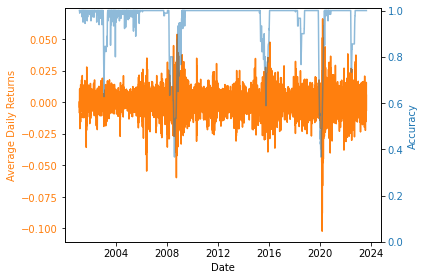

In [21]:
# Initialize an empty list to store average returns
average_daily_returns = []
daily_std_devs = []

# Loop through each day in the returns DataFrame
for date in returns.index:
    # Select the market cap for the current day
    current_market_cap = market_cap.loc[date]
    
    # Find the top 60 stocks by market cap for the current day
    top_60_stocks = current_market_cap.nlargest(60).index
    
    # Select the returns for the top 60 stocks
    current_returns = returns.loc[date, top_60_stocks]
    
    # Calculate the average return for the current day for the top 60 stocks
    average_return = current_returns.mean()
    
    daily_vol = current_returns.std()
    
    # Store the average return
    average_daily_returns.append(average_return)
    daily_std_devs.append(daily_vol)

# Convert the average daily returns list into a pandas Series
average_daily_returns_series = pd.Series(average_daily_returns, index=returns.index)

daily_std_devs_series = pd.Series(daily_std_devs, index=returns.index)

# Adjust the selection of average daily returns to match the specified period
# Ending 75 days before the end of the time series, covering 5871 days
end_index = -75  # End 75 days before the end of the time series
start_index = end_index - 5871  # Start from 5871 days before the end_index
aligned_average_daily_returns_series = average_daily_returns_series[start_index:end_index]
aligned_vols = daily_std_devs_series[start_index:end_index]

# Ensure block_accuracies is a pandas Series with the correct dates
block_accuracies_series = pd.Series(block_accuracies, index=aligned_average_daily_returns_series.index)

# Plotting
fig, ax1 = plt.subplots()

# Configure the first y-axis (left side) for the average daily returns
color = 'tab:orange'
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Daily Returns', color=color)
ax1.plot(aligned_average_daily_returns_series.index, aligned_average_daily_returns_series, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create and configure the second y-axis (right side) for the block accuracies
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(block_accuracies_series.index, block_accuracies, color=color, marker='', linestyle='-', alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 1.01])  # Focus the accuracy axis from 90% to 100%

# Finalize plot
fig.tight_layout()
plt.savefig('top60_spdnet_accuracy_vs_rets.png', bbox_inches='tight')
plt.show()


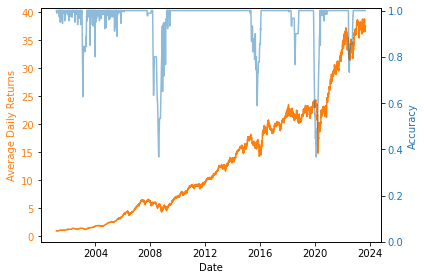

In [22]:
cumulative_returns = (1 + aligned_average_daily_returns_series).cumprod()

# Plotting
fig, ax1 = plt.subplots()

# Configure the first y-axis (left side) for the average daily returns
color = 'tab:orange'
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Daily Returns', color=color)
ax1.plot(aligned_average_daily_returns_series.index, cumulative_returns, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create and configure the second y-axis (right side) for the block accuracies
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(block_accuracies_series.index, block_accuracies, color=color, marker='', linestyle='-', alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 1.01])  # Focus the accuracy axis from 90% to 100%

# Finalize plot
fig.tight_layout()
plt.savefig('top60_spdnet_accuracy_vs_cumrets.png', bbox_inches='tight')
plt.show()

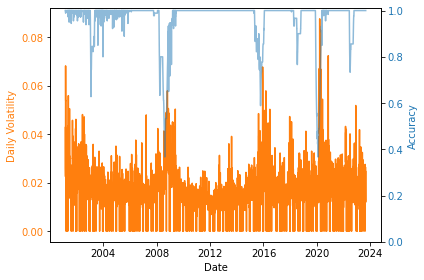

In [23]:
# Plotting
fig, ax1 = plt.subplots()

# Configure the first y-axis (left side) for the average daily returns
color = 'tab:orange'
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Volatility', color=color)
ax1.plot(aligned_vols.index, aligned_vols, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create and configure the second y-axis (right side) for the block accuracies
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(block_accuracies_series.index, block_accuracies, color=color, marker='', linestyle='-', alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 1.01])  # Focus the accuracy axis from 90% to 100%

# Finalize plot
fig.tight_layout()
plt.savefig('top60_spdnet_accuracy_vs_vol.png', bbox_inches='tight')
plt.show()

In [24]:
import numpy as np

# Assuming `volatility_series` and `block_accuracies_series` are pandas Series indexed by date
# and have the same length
contemporaneous_corr = np.corrcoef(aligned_vols, block_accuracies_series)[0, 1]

print(f"Contemporaneous correlation: {contemporaneous_corr}")


Contemporaneous correlation: -0.21974529094196876


In [29]:
lag_correlations = {}

# Check lags from -5 to 5 days
for lag in range(-252, 252):
    if lag < 0:
        shifted_volatility = aligned_vols[:lag]  # Shift backward for negative lags
        aligned_accuracy = block_accuracies_series[-lag:]
    elif lag > 0:
        shifted_volatility = aligned_vols[lag:]  # Shift forward for positive lags
        aligned_accuracy = block_accuracies_series[:-lag]
    else:  # lag == 0, contemporaneous, already calculated
        continue
    
    # Calculate correlation for this lag
    corr = np.corrcoef(shifted_volatility, aligned_accuracy)[0, 1]
    lag_correlations[lag] = corr

# Display the correlations for each lag
for lag, corr in lag_correlations.items():
    print(f"Lag {lag}: Correlation = {corr}")


Lag -252: Correlation = 0.04611080779289925
Lag -251: Correlation = 0.045462426275020396
Lag -250: Correlation = 0.046305310810444214
Lag -249: Correlation = 0.045852231433481
Lag -248: Correlation = 0.04381202559975423
Lag -247: Correlation = 0.043321440750958035
Lag -246: Correlation = 0.04285805784543055
Lag -245: Correlation = 0.04308225800443857
Lag -244: Correlation = 0.0411929437477005
Lag -243: Correlation = 0.042669069455810324
Lag -242: Correlation = 0.04240083742190528
Lag -241: Correlation = 0.038415210380192244
Lag -240: Correlation = 0.03793349553176303
Lag -239: Correlation = 0.03859574897019395
Lag -238: Correlation = 0.03772940193360636
Lag -237: Correlation = 0.034547976037694966
Lag -236: Correlation = 0.03663657817100993
Lag -235: Correlation = 0.03535659996924722
Lag -234: Correlation = 0.03469364710980178
Lag -233: Correlation = 0.03241906985693784
Lag -232: Correlation = 0.031111570095290298
Lag -231: Correlation = 0.035660482106895826
Lag -230: Correlation = 0.0

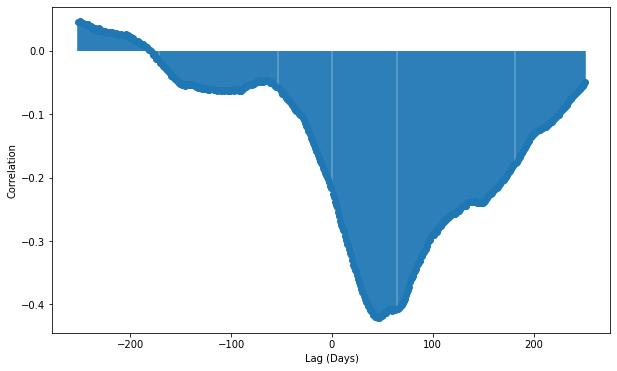

In [31]:
import matplotlib.pyplot as plt

lags = list(lag_correlations.keys())
correlations = list(lag_correlations.values())

plt.figure(figsize=(10, 6))
plt.stem(lags, correlations, basefmt=" ", use_line_collection=True)
plt.xlabel('Lag (Days)')
plt.ylabel('Correlation')
plt.savefig('top60_spdnet_corr_lag.png', bbox_inches='tight')
plt.show()


## Creating data for U-SPDNet

In [46]:
def ensure_label_directories_exist(path, categories):
    """
    Ensure that directories for each label exist within the specified path.
    Args:
    - path: The base path where the directories should be created.
    - categories: A list of categories ('train', 'val') for which subdirectories should be ensured.
    """
    for category in categories:
        category_path = os.path.join(path, category)
        for label in ['1', '2', '3']:  # Create a directory for each label
            label_dir = os.path.join(category_path, label)
            os.makedirs(label_dir, exist_ok=True)

def save_as_mat(data, labels, path, category):
    """
    Save the data (correlation matrices) and labels in .mat format into specific folders.
    Args:
    - data: List of numpy arrays (correlation matrices).
    - labels: Corresponding labels for the data.
    - path: Base path for saving the files.
    - category: 'train' or 'val' indicating the category of the data.
    """
    for i, (matrix, label) in enumerate(zip(data, labels)):
        # Adjust the label to match the folder naming convention
        label_dir = os.path.join(path, category, str(label + 1))  # Adjust label for folder name
        file_path = os.path.join(label_dir, f"matrix_{i}.mat")
        scipy.io.savemat(file_path, {"matrix": matrix})


# Iterate over each block to organize and save the data
for block_number in range(len(training_data)):
    block_dir = os.path.join(base_dir, f"block_{block_number}")
    
    # Ensure label directories exist for both training and validation data
    ensure_label_directories_exist(block_dir, ['train', 'val'])
    
    # Paths for training and validation (test) data within each block
    train_path = os.path.join(block_dir, "train")
    val_path = os.path.join(block_dir, "val")
    
    # Save training data and labels
    save_as_mat(training_data[block_number], training_labels[block_number], block_dir, "train")
    
    # Save testing/validation data and labels
    save_as_mat(testing_data[block_number], testing_labels[block_number], block_dir, "val")



In [47]:
import os
import numpy as np
from scipy.io import savemat

# Base directory for UAV_CONV data
base_dir = '/Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks'  # Update this path to your directory

# Labels and their corresponding numeric values
label_map = {'1': 1, '2': 2, '3': 3}

def create_label_dirs(category_dir):
    """
    Ensure that label directories 1, 2, and 3 exist in the category directory.
    """
    for label in ['1', '2', '3']:
        label_dir = os.path.join(category_dir, label)
        os.makedirs(label_dir, exist_ok=True)

def process_block(block_dir):
    """
    Process each block directory and save the corresponding .mat file.
    """
    # Initialize the spd structure for the current block
    print(f"Processing {block_dir_path}")
    spd = {'name': [], 'id': [], 'set': [], 'label': []}

    for category in ['train', 'val']:
        category_dir = os.path.join(block_dir, category)
        create_label_dirs(category_dir)  # Ensure label directories exist
        set_val = 1 if category == 'train' else 2  # 1 for train, 2 for val

        for label_dir_name in ['1', '2', '3']:  # Use label map keys to ensure consistency
            label_dir_path = os.path.join(category_dir, label_dir_name)
            for file_name in os.listdir(label_dir_path):
                if file_name.endswith('.mat'):
                    # Construct file path
                    filepath = os.path.join(label_dir_path, file_name)
                    # Add the entry to the spd structure
                    relative_path = os.path.relpath(filepath, base_dir)
                    spd['name'].append(relative_path)
                    spd['id'].append(len(spd['id']) + 1)
                    spd['set'].append(set_val)
                    spd['label'].append(label_map[label_dir_name])

    # Convert lists to arrays for MATLAB compatibility
    for key in ['name', 'id', 'set', 'label']:
        spd[key] = np.array(spd[key], dtype=object if key == 'name' else np.double)

    # Extract block number from the directory name
    block_number = block_dir.split('_')[-1]

    # Modify SpdDir for the current block
    SpdDir = np.array([f'scratch/ortale003/data/afew/UAV_CONV/block_{block_number}'], dtype=object)

    # Create the final structure to be saved for the current block
    spd_train = {'spd': spd, 'SpdDir': SpdDir}
    print(f"Saving {os.path.join(base_dir, f'sample_for_SPDNet_UAV_{block_number}.mat')}")

    # Save the spd_train structure to a .mat file for the current block
    savemat(os.path.join(base_dir, f'sample_for_SPDNet_UAV_{block_number}.mat'), {'spd_train': spd_train})

# Loop through each block directory and process it
for item in os.listdir(base_dir):
    block_dir_path = os.path.join(base_dir, item)
    if os.path.isdir(block_dir_path) and item.startswith('block_'):
        process_block(block_dir_path)


Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5078
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5078.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_27
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_27.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5844
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5844.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_953
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_953.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4996
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4996.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3981
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3981.ma

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1245
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1245.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3512
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3512.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3972
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3972.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1619
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1619.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4159
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4159.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4965
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_398
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_398.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3178
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3178.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2896
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2896.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3944
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3944.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2298
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2298.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4953
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_495

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2059
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2059.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2865
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2865.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4168
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4168.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4954
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4954.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_991
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_991.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5288
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_528

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2032
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2032.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5673
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5673.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_764
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_764.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3584
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3584.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2456
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2456.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2664
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_266

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5680
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5680.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4752
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4752.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3577
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3577.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2663
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2663.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5446
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5446.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_551
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_55

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3317
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3317.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2003
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2003.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1686
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1686.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_331
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_331.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5226
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5226.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5828
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_582

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1447
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1447.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4909
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4909.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4135
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4135.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3310
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3310.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3122
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3122.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1675
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1

Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4156.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_193
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_193.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5084
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5084.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3373
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3373.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2093
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2093.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3141
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3141.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_160
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_160.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2252
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2252.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3380
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3380.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2094
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2094.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3146
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3146.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1611
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_161

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5617
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5617.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2432
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2432.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3726
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3726.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1071
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1071.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4503
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4503.ma

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3721
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3721.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1076
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1076.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4504
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4504.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5610
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5610.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_707
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_707.mat


Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3578
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3578.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2698
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2698.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1821
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1821.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_86
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_86.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1479
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1479.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4937
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4937.

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2459
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2459.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5218
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5218.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2801
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2801.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_901
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_901.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5816
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5816.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_75
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_75.ma

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_937
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_937.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5820
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5820.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_43
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_43.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2239
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2239.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5478
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5478.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4798
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4798.ma

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1817
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1817.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4559
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4559.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2468
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2468.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_568
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_568.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3788
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3788.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_44
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_44.ma

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4626
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4626.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3403
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3403.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3863
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3863.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1708
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1708.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4874
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4874.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4048
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_289
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_289.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3855
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3855.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2987
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2987.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3069
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3069.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2389
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2389.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_887
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_887.

Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2177.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5352
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5352.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_245
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_245.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4280
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4280.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5160
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5160.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3297
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3297.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4476
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4476.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1938
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1938.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1104
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1104.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3237
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3237.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4012
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4012.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1560
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2124
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2124.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2918
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2918.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2316
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2316.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5133
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5133.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_818
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_818.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1593
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_159

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4478
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4478.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2549
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2549.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_449
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_449.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_811
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_811.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5308
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5308.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2911
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2911.

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4078
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4078.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_881
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_881.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4844
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4844.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3639
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3639.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1952
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1952.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5708
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_570

Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5502.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2727
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2727.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2515
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2515.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5730
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5730.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_627
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_627.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1390
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1390.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block

Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2523.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3637
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3637.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4412
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4412.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1160
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1160.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4620
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4620.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1352
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1352.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/blo

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2524
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2524.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2716
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2716.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5533
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5533.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_424
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_424.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1193
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1193.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2372
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_237

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1568
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1568.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4228
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4228.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3831
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3831.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2319
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2319.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_817
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_817.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_219
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_219.

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5799
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5799.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_673
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_673.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5764
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5764.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2541
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2541.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3493
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3493.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2773
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_277

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4645
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4645.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5797
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5797.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_680
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_680.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3460
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3460.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1753
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1753.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4221
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_422

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3026
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3026.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1315
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1315.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4667
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4667.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3442
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3442.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2590
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2590.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3670
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1120
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1120.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_497
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_497.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5580
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5580.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4452
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4452.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1312
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1312.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4660
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_466

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_693
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_693.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1778
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1778.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3813
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3813.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4804
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4804.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4038
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4038.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3679
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_367

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4261
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4261.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1713
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1713.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3044
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3044.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2196
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2196.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3878
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3878.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3276
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5340
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5340.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4292
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4292.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2165
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2165.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2959
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2959.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3271
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3271.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5186
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3623
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3623.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4062
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4062.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1510
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1510.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2395
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2395.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3247
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3247.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3075
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3

Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2154.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3086
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3086.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2968
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2968.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5371
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5371.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_266
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_266.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4091
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4091.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3647
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3647.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3475
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3475.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4650
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4650.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5782
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5782.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_695
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_695.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1322
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_132

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1748
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1748.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4008
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4008.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4834
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4834.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1922
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1922.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3649
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3649.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4498
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4833
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4833.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3018
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3018.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3824
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3824.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3685
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3685.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2757
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2757.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_465
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_46

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4256
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4256.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_293
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_293.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5384
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5384.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3417
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3417.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1340
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1340.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4632
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_463

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5521
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5521.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2704
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2704.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2536
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2536.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5713
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5713.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_604
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_604.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3279
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_327

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4856
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4856.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3841
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3841.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2993
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2993.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4258
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4258.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_867
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_867.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2369
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_236

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1835
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1835.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1009
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1009.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4749
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4749.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3108
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3108.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3934
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3934.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_92
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_92.

Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_129.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_61
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_61.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5802
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5802.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_915
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_915.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2029
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2029.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2815
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2815.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4118

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4778
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4778.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5498
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5498.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1804
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1804.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1038
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1038.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4912
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4912.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3139
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_118
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_118.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_924
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_924.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5833
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5833.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_50
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_50.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3565
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3565.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5692
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5692.mat


Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2241
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2241.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3393
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3393.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5858
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5858.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5064
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5064.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_173
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_173.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2625
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_262

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5097
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5097.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1605
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1605.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4377
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4377.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2080
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2080.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3152
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3152.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1261
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1401
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1401.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4173
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4173.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3356
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3356.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2284
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2284.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3958
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3958.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3164
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2045
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2045.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_377
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_377.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5260
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5260.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_979
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_979.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5052
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5052.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_145
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_145.ma

Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_770.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5667
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5667.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1001
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1001.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4573
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4573.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3756
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3756.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2684
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2684.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/bloc

Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4580.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2677
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2677.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1496
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1496.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_69
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_69.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_121
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_121.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5036
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5036.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_221

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2641
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2641.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3793
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3793.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_573
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_573.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5464
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5464.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5804
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5804.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_67
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_67.ma

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_520
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_520.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5437
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5437.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1097
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1097.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2612
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2612.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_144
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_144.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5053
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5053.

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1064
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1064.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3733
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3733.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3501
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3501.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4724
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4724.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1256
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1256.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3165
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4376
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4376.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1604
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1604.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2081
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2081.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3153
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3153.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3361
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3361.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4144
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4385
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4385.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5257
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5257.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_340
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_340.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2072
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2072.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5633
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5633.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_724
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_724.

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3746
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3746.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1011
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1011.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4563
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4563.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_760
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_760.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5677
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5677.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2452
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_245

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5684
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5684.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_793
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_793.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3573
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3573.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1640
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1640.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4332
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4332.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3117
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_311

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3545
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3545.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2497
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2497.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1212
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1212.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4760
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4760.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_904
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_904.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_70
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_70.ma

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1018
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1018.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1824
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1824.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4758
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4758.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2669
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2669.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_769
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_769.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3589
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_358

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_968
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_968.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2602
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2602.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_530
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_530.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5427
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5427.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1087
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1087.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5615
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5615.

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3175
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3175.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3949
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3949.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4734
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4734.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1246
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1246.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3511
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3511.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3723
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3143
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3143.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2091
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2091.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4366
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4366.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1614
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1614.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1248
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1248.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4508
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3382
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3382.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2250
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2250.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2001
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2001.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5224
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5224.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_333
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_333.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1684
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_168

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1445
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1445.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3312
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3312.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3120
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3120.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4305
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4305.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1677
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1677.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3544
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2692
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2692.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3740
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3740.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4565
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4565.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1017
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1017.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3324
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3324.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4101
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4

Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2205.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_137
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_137.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5020
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5020.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1480
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1480.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4334
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4334.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1646
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1646.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1282
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1282.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_735
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_735.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5622
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5622.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5410
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5410.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_507
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_507.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2635
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2635.

Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4703.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3142
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3142.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2090
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2090.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1615
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1615.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4367
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4367.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1427
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1427.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/blo

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1411
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1411.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4163
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4163.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3722
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3722.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1075
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1075.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1849
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1849.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4507
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2055
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2055.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3187
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3187.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_703
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_703.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5614
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5614.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2431
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2431.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2603
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_260

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1590
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1590.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5302
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5302.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_215
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_215.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2127
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2127.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_488
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_488.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1903
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1903.

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4812
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4812.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3039
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3039.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3805
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3805.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4678
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4678.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5598
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5598.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1904
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5596
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5596.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1136
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1136.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3661
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3661.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4020
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4020.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1552
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1552.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3205
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4622
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4622.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3407
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3407.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1734
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1734.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_283
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_283.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5394
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5394.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4246
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_424

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5531
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5531.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2370
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2370.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5155
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5155.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4087
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4087.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5367
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5367.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_270
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_27

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5507
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5507.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2722
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2722.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3436
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3436.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1361
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1361.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4613
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4613.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1153
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2725
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2725.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2517
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2517.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1392
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1392.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_625
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_625.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5732
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5732.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2173
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_217

Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1554.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4026
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4026.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3203
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3203.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3031
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3031.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1766
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1766.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4214
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4214.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/blo

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2313
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2313.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1596
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1596.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5136
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5136.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5304
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5304.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_213
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_213.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2121
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_212

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4473
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4473.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1333
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1333.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_684
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_684.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5793
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5793.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4641
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4641.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3464
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_346

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3430
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3430.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4615
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4615.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1367
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1367.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1969
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1969.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4427
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4427.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1155
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2511
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2511.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_623
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_623.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5734
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5734.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1394
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1394.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1369
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1369.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4429
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_442

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_847
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_847.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4882
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4882.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2349
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2349.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3861
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3861.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4278
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4278.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5198
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_519

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3888
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3888.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2354
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2354.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3286
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3286.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5171
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5171.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4265
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4265.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1717
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5344
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5344.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_253
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_253.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2161
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2161.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5720
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5720.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_637
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_637.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1380
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1380.

Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2365.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3085
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3085.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2157
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2157.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5372
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5372.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_265
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_265.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3618
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3618.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2739
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2739.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1980
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1980.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5178
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5178.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_853
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_853.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4896
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4896.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4298
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_429

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4451
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4451.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_494
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_494.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5583
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5583.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3210
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3210.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1547
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1547.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4809
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_480

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4209
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4209.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3810
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3810.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3448
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3448.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1911
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1911.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4699
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4699.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5579
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1318
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1318.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3817
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3817.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3219
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3219.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4800
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4800.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3484
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3484.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2556
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3083
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3083.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2151
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2151.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5374
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5374.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_263
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_263.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2535
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2535.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5710
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_571

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4631
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4631.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3289
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3289.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_855
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_855.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4890
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4890.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3887
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3887.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2955
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_295

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2963
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2963.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4852
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4852.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_897
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_897.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2399
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2399.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2997
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2997.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3845
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_384

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4069
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4069.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2964
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2964.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2158
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2158.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_864
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_864.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5719
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5719.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1319
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_131

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4208
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4208.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3811
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3811.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4806
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4806.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1548
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1548.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1910
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1910.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3449
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3229
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3229.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4691
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4691.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5743
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5743.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_654
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_654.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2566
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2566.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2754
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_275

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2595
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2595.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3447
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3447.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4206
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4206.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1774
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1774.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3023
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3023.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3211
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5094
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5094.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4146
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4146.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3707
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3707.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1050
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1050.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4522
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4522.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1262
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_726
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_726.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5631
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5631.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2414
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2414.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2626
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2626.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5403
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5403.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_514
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_514.

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1608
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1608.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3963
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3963.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4974
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4974.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4148
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4148.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2845
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2845.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3997
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2628
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2628.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1891
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1891.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4987
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4987.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_942
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_942.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_36
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_36.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5855
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5855.ma

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_585
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_585.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4540
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4540.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1032
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1032.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3301
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3301.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4124
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4124.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4918
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_491

Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1697.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2012
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2012.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2220
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2220.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_112
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_112.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5005
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5005.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5839
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5839.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2820
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2820.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_54
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_54.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5837
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5837.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_920
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_920.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3798
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3798.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_578
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_578.mat


Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1403
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1403.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2286
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2286.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3354
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3354.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3166
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3166.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2888
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2888.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4343
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4

Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3195.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5262
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5262.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_375
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_375.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4182
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4182.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_147
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_147.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5050
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5050.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5630
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5630.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_727
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_727.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1290
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1290.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2415
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2415.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3701
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3701.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4524
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_452

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2412
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2412.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2620
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2620.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5405
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5405.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1899
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1899.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_512
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_512.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3396
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_339

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1005
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1005.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4577
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4577.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1839
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1839.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2680
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2680.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3752
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3752.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3560
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3593
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3593.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_773
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_773.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5664
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5664.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4584
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4584.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5456
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5456.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_541
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_541.

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5236
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5236.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2013
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_2013.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_3307
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_3307.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1450
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1450.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4122
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4122.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1662
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1

Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1457
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1457.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_4125
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_4125.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_1691
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_1691.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_5231
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_5231.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_326
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_326.mat
Processing /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/block_2828
Saving /Users/alexa/Documents/MATLAB/U-SPDNet/UAVCONV_blocks/sample_for_SPDNet_UAV_282